In [ ]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from scipy.stats import zscore


nombre_csv=1
df= pd.read_csv(f'Data1_actividad/{nombre_csv}.csv')


def analyze_circadian_patterns(df):
    """
    Analiza los patrones circadianos y detecta cambios abruptos en la actividad
    considerando la continuidad temporal y la influencia de actividades previas.
    """
    # Crear una columna de tiempo continuo
    # Convertir 'Fecha' y 'Hora' a datetime
    df['datetime'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'].astype(str) + ':00:00')
    df = df.set_index('datetime')
    df = df.sort_index()
    
    # Calcular ciclos circadianos usando ventana móvil de 24 horas
    window_size = 24
    
    def extract_circadian_cycle(data):
        fft_result = fft(data)
        n = len(data)
        freq = np.fft.fftfreq(n, d=1/24)
        fft_filtered = fft_result.copy()
        fft_filtered[(freq < 0.8) | (freq > 1.2)] = 0
        return np.real(ifft(fft_filtered))
    
    # Calcular métricas de actividad y variabilidad
    metrics = []
    
    # Usar ventana deslizante para análisis continuo
    for i in range(len(df) ):
        window = df.iloc[i:i+window_size]
        
        # Extraer ciclo circadiano para la ventana actual
        cycle_1 = extract_circadian_cycle(window['activity_level'].values)
        cycle_2 = extract_circadian_cycle(window['activity_level_2'].values)
        
        # Calcular métricas para la última hora de la ventana
        current_time = window.index[-1]
        
        # Calcular variabilidad y cambios abruptos
        activity_std_1 = np.std(window['activity_level'])
        activity_std_2 = np.std(window['activity_level_2'])
        
        # Detectar cambios abruptos usando diferencias
        activity_diff_1 = np.diff(window['activity_level'].values)
        activity_diff_2 = np.diff(window['activity_level_2'].values)
        
        
        # Analizar patrones de comportamiento
        eating_pattern = window['period eating'].values
        resting_pattern = window['period resting'].values
        rumination_pattern = window['period rumination'].values
        
        # Detectar desviaciones significativas
        z_scores_1 = zscore(window['activity_level'])
        print( z_scores_1)
        z_scores_2 = zscore(window['activity_level_2'])
        
        # Calcular métricas compuestas
        composite_score = (
            np.abs(z_scores_1[-1]) + 
            np.abs(z_scores_2[-1]) + 
            np.max(np.abs(activity_diff_1[-6:])) +  # Últimas 6 horas
            np.max(np.abs(activity_diff_2[-6:]))
        ) / 4
        
        print(composite_score)
        
        # Determinar nivel de estrés basado en múltiples factores
        def determine_stress_level(score, patterns):
            eating, resting, rumination = patterns
            
            # Factores de riesgo
            risk_factors = []
            
            # Analizar patrones de comportamiento anormales
            if eating[-1] < np.mean(eating) - np.std(eating):
                risk_factors.append('reducción_alimentación')
            if resting[-1] < np.mean(resting) - np.std(resting):
                risk_factors.append('reducción_descanso')
            if rumination[-1] < np.mean(rumination) - np.std(rumination):
                risk_factors.append('reducción_rumia')
                
            # Evaluar nivel de estrés
            if score < 1.5 and len(risk_factors) == 0:
                return 'normal', risk_factors
            elif score < 2.5 or (score < 2.0 and len(risk_factors) > 0):
                return 'alerta', risk_factors
            else:
                return 'peligro', risk_factors
        
        stress_level, risk_factors = determine_stress_level(
            composite_score, 
            (eating_pattern, resting_pattern, rumination_pattern)
        )
        
        metrics.append({
            'datetime': current_time,
            'composite_score': composite_score,
            'stress_level': stress_level,
            'risk_factors': risk_factors,
            'activity_variability_1': activity_std_1,
            'activity_variability_2': activity_std_2,
            'recent_change_1': np.max(np.abs(activity_diff_1[-6:])),
            'recent_change_2': np.max(np.abs(activity_diff_2[-6:]))
        })
    
    # Convertir resultados a DataFrame
    results_df = pd.DataFrame(metrics)
    results_df.set_index('datetime', inplace=True)
    
    return results_df

# Analizar los datos
results = analyze_circadian_patterns(df)


datetime
2024-01-01 00:00:00   -0.656313
2024-01-01 01:00:00   -1.157193
2024-01-01 02:00:00   -0.824737
2024-01-01 03:00:00   -0.854960
2024-01-01 04:00:00   -1.251044
2024-01-01 05:00:00   -1.058247
2024-01-01 06:00:00   -1.319108
2024-01-01 07:00:00    1.347418
2024-01-01 08:00:00    1.407060
2024-01-01 09:00:00    1.389772
2024-01-01 10:00:00   -0.245722
2024-01-01 11:00:00    0.100601
2024-01-01 12:00:00    1.347418
2024-01-01 13:00:00    1.347418
2024-01-01 14:00:00    0.153342
2024-01-01 15:00:00   -1.055903
2024-01-01 16:00:00    0.478128
2024-01-01 17:00:00    1.347418
2024-01-01 18:00:00    1.347418
2024-01-01 19:00:00    0.431176
2024-01-01 20:00:00   -0.543183
2024-01-01 21:00:00   -0.824737
2024-01-01 22:00:00   -0.008112
2024-01-01 23:00:00   -0.897909
Name: activity_level, dtype: float64
0.8668432174336742
datetime
2024-01-01 01:00:00   -1.107340
2024-01-01 02:00:00   -0.782302
2024-01-01 03:00:00   -0.811851
2024-01-01 04:00:00   -1.199097
2024-01-01 05:00:00   -1.01060

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-02 11:00:00   -0.423935
2024-01-02 12:00:00    0.549275
2024-01-02 13:00:00    0.878532
2024-01-02 14:00:00    0.648278
2024-01-02 15:00:00    1.294119
2024-01-02 16:00:00    1.164959
2024-01-02 17:00:00    1.164959
2024-01-02 18:00:00    0.680509
2024-01-02 19:00:00   -0.598902
2024-01-02 20:00:00   -0.800751
2024-01-02 21:00:00   -1.156562
2024-01-02 22:00:00   -0.848306
2024-01-02 23:00:00    1.164959
2024-01-03 00:00:00    0.584422
2024-01-03 01:00:00   -0.693000
2024-01-03 02:00:00   -1.221162
2024-01-03 03:00:00   -0.601664
2024-01-03 04:00:00   -2.019553
2024-01-03 05:00:00   -0.534637
2024-01-03 06:00:00   -1.569009
2024-01-03 07:00:00   -0.654258
2024-01-03 08:00:00    1.164959
2024-01-03 09:00:00    1.142668
2024-01-03 10:00:00    0.684098
Name: activity_level, dtype: float64
0.7512298425868082
datetime
2024-01-02 12:00:00    0.536462
2024-01-02 13:00:00    0.866963
2024-01-02 14:00:00    0.635839
2024-01-02 15:00:00    1.284121
2024-01-02 16:00:00    1.15447

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-03 22:00:00   -0.288121
2024-01-03 23:00:00    0.685547
2024-01-04 00:00:00   -0.643833
2024-01-04 01:00:00   -1.343215
2024-01-04 02:00:00   -0.271412
2024-01-04 03:00:00   -0.867635
2024-01-04 04:00:00   -0.914844
2024-01-04 05:00:00   -0.120938
2024-01-04 06:00:00   -1.607232
2024-01-04 07:00:00    1.198276
2024-01-04 08:00:00    1.616107
2024-01-04 09:00:00    0.564276
2024-01-04 10:00:00    1.011043
2024-01-04 11:00:00   -0.988279
2024-01-04 12:00:00   -0.774860
2024-01-04 13:00:00   -0.436296
2024-01-04 14:00:00   -0.913695
2024-01-04 15:00:00    0.596388
2024-01-04 16:00:00    1.616107
2024-01-04 17:00:00    1.616107
2024-01-04 18:00:00    1.426941
2024-01-04 19:00:00    0.003095
2024-01-04 20:00:00    0.003095
2024-01-04 21:00:00   -1.166621
Name: activity_level, dtype: float64
0.6800745026236463
datetime
2024-01-03 23:00:00    0.674630
2024-01-04 00:00:00   -0.657153
2024-01-04 01:00:00   -1.357799
2024-01-04 02:00:00   -0.284059
2024-01-04 03:00:00   -0.88136

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

0.8167029536338595
datetime
2024-01-06 03:00:00   -1.087718
2024-01-06 04:00:00   -0.819396
2024-01-06 05:00:00   -0.841739
2024-01-06 06:00:00   -1.081906
2024-01-06 07:00:00   -0.474041
2024-01-06 08:00:00    1.230434
2024-01-06 09:00:00    1.230434
2024-01-06 10:00:00   -0.923526
2024-01-06 11:00:00    1.230434
2024-01-06 12:00:00    1.208049
2024-01-06 13:00:00    0.011126
2024-01-06 14:00:00   -1.457470
2024-01-06 15:00:00    1.145499
2024-01-06 16:00:00    1.230434
2024-01-06 17:00:00    1.262177
2024-01-06 18:00:00    1.516117
2024-01-06 19:00:00    0.255082
2024-01-06 20:00:00   -0.328108
2024-01-06 21:00:00   -1.211826
2024-01-06 22:00:00    0.586516
2024-01-06 23:00:00   -0.105557
2024-01-07 00:00:00   -0.647145
2024-01-07 01:00:00   -0.774461
2024-01-07 02:00:00   -1.153411
Name: activity_level, dtype: float64
0.8112918484504521
datetime
2024-01-06 04:00:00   -0.883295
2024-01-06 05:00:00   -0.906226
2024-01-06 06:00:00   -1.152710
2024-01-06 07:00:00   -0.528856
2024-01-06 

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-07 16:00:00    1.499723
2024-01-07 17:00:00    1.390979
2024-01-07 18:00:00    1.460096
2024-01-07 19:00:00    0.204641
2024-01-07 20:00:00   -0.305091
2024-01-07 21:00:00   -0.697272
2024-01-07 22:00:00   -0.518196
2024-01-07 23:00:00    1.390979
2024-01-08 00:00:00    0.823655
2024-01-08 01:00:00   -0.478844
2024-01-08 02:00:00   -0.974055
2024-01-08 03:00:00   -0.907914
2024-01-08 04:00:00    0.046860
2024-01-08 05:00:00   -1.303065
2024-01-08 06:00:00    0.109322
2024-01-08 07:00:00   -0.447934
2024-01-08 08:00:00   -0.572633
2024-01-08 09:00:00   -1.298846
2024-01-08 10:00:00    1.390979
2024-01-08 11:00:00    1.263820
2024-01-08 12:00:00   -1.869506
2024-01-08 13:00:00    0.812775
2024-01-08 14:00:00   -0.656450
2024-01-08 15:00:00   -0.364022
Name: activity_level, dtype: float64
0.999077814422441
datetime
2024-01-07 17:00:00    1.404755
2024-01-07 18:00:00    1.474329
2024-01-07 19:00:00    0.210558
2024-01-07 20:00:00   -0.302551
2024-01-07 21:00:00   -0.697330

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-08 12:00:00   -1.701647
2024-01-08 13:00:00    0.895707
2024-01-08 14:00:00   -0.526999
2024-01-08 15:00:00   -0.243830
2024-01-08 16:00:00    1.455605
2024-01-08 17:00:00    1.455605
2024-01-08 18:00:00    1.283312
2024-01-08 19:00:00   -0.755732
2024-01-08 20:00:00   -0.928340
2024-01-08 21:00:00   -1.167921
2024-01-08 22:00:00    0.501629
2024-01-08 23:00:00    0.959916
2024-01-09 00:00:00   -0.409210
2024-01-09 01:00:00   -1.259886
2024-01-09 02:00:00   -0.399356
2024-01-09 03:00:00   -1.529213
2024-01-09 04:00:00   -0.059414
2024-01-09 05:00:00   -0.848564
2024-01-09 06:00:00    0.391565
2024-01-09 07:00:00    1.679357
2024-01-09 08:00:00    0.628405
2024-01-09 09:00:00   -0.552408
2024-01-09 10:00:00   -0.074760
2024-01-09 11:00:00    1.206182
Name: activity_level, dtype: float64
0.7931491704092339
datetime
2024-01-08 13:00:00    0.874873
2024-01-08 14:00:00   -0.646580
2024-01-08 15:00:00   -0.343756
2024-01-08 16:00:00    1.473631
2024-01-08 17:00:00    1.47363

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-11 00:00:00   -1.347697
2024-01-11 01:00:00   -0.923048
2024-01-11 02:00:00   -0.938434
2024-01-11 03:00:00   -0.727648
2024-01-11 04:00:00   -0.674724
2024-01-11 05:00:00   -0.969586
2024-01-11 06:00:00   -1.343081
2024-01-11 07:00:00    0.226567
2024-01-11 08:00:00    1.381222
2024-01-11 09:00:00    1.315173
2024-01-11 10:00:00    1.214533
2024-01-11 11:00:00   -0.349188
2024-01-11 12:00:00    1.282567
2024-01-11 13:00:00    0.933525
2024-01-11 14:00:00   -0.591612
2024-01-11 15:00:00    0.547279
2024-01-11 16:00:00    1.282567
2024-01-11 17:00:00    1.282567
2024-01-11 18:00:00    1.282567
2024-01-11 19:00:00   -0.034505
2024-01-11 20:00:00   -0.182989
2024-01-11 21:00:00   -1.059982
2024-01-11 22:00:00   -0.136831
2024-01-11 23:00:00   -1.469245
Name: activity_level, dtype: float64
0.8196255917348743
datetime
2024-01-11 01:00:00   -1.010343
2024-01-11 02:00:00   -1.026352
2024-01-11 03:00:00   -0.807026
2024-01-11 04:00:00   -0.751957
2024-01-11 05:00:00   -1.05876

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-13 10:00:00    0.272742
2024-01-13 11:00:00    1.134196
2024-01-13 12:00:00    1.333973
2024-01-13 13:00:00    0.366718
2024-01-13 14:00:00   -0.521712
2024-01-13 15:00:00    1.055179
2024-01-13 16:00:00    1.333973
2024-01-13 17:00:00   -0.190647
2024-01-13 18:00:00    1.212802
2024-01-13 19:00:00    0.658791
2024-01-13 20:00:00   -0.156904
2024-01-13 21:00:00   -1.438443
2024-01-13 22:00:00   -0.273260
2024-01-13 23:00:00   -1.370602
2024-01-14 00:00:00   -0.357850
2024-01-14 01:00:00   -1.100685
2024-01-14 02:00:00   -0.612634
2024-01-14 03:00:00   -1.280069
2024-01-14 04:00:00   -0.877669
2024-01-14 05:00:00   -1.112976
2024-01-14 06:00:00   -1.461068
2024-01-14 07:00:00    0.718199
2024-01-14 08:00:00    1.333973
2024-01-14 09:00:00    1.333973
Name: activity_level, dtype: float64
1.0016685255640145
datetime
2024-01-13 11:00:00    1.133588
2024-01-13 12:00:00    1.333340
2024-01-13 13:00:00    0.366209
2024-01-13 14:00:00   -0.522107
2024-01-13 15:00:00    1.05458

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-15 12:00:00    1.362043
2024-01-15 13:00:00   -0.043803
2024-01-15 14:00:00   -1.065899
2024-01-15 15:00:00    0.533197
2024-01-15 16:00:00    1.362043
2024-01-15 17:00:00    1.362043
2024-01-15 18:00:00    0.772375
2024-01-15 19:00:00   -0.033519
2024-01-15 20:00:00   -0.261569
2024-01-15 21:00:00    0.899314
2024-01-15 22:00:00    0.813262
2024-01-15 23:00:00   -1.023625
2024-01-16 00:00:00   -1.507610
2024-01-16 01:00:00   -0.874030
2024-01-16 02:00:00   -0.896909
2024-01-16 03:00:00   -1.484731
2024-01-16 04:00:00   -0.284448
2024-01-16 05:00:00   -0.801817
2024-01-16 06:00:00   -1.036638
2024-01-16 07:00:00    1.437594
2024-01-16 08:00:00    1.362043
2024-01-16 09:00:00   -0.258681
2024-01-16 10:00:00   -1.150341
2024-01-16 11:00:00    0.819704
Name: activity_level, dtype: float64
0.7776755246814252
datetime
2024-01-15 13:00:00    0.006843
2024-01-15 14:00:00   -1.058105
2024-01-15 15:00:00    0.608034
2024-01-15 16:00:00    1.471631
2024-01-15 17:00:00    1.47163

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-17 10:00:00    1.205826
2024-01-17 11:00:00   -0.941403
2024-01-17 12:00:00   -1.251642
2024-01-17 13:00:00    1.205826
2024-01-17 14:00:00   -0.187396
2024-01-17 15:00:00   -0.186230
2024-01-17 16:00:00    1.338613
2024-01-17 17:00:00    1.205826
2024-01-17 18:00:00    1.205826
2024-01-17 19:00:00    0.451980
2024-01-17 20:00:00   -0.276766
2024-01-17 21:00:00   -1.111220
2024-01-17 22:00:00   -1.061226
2024-01-17 23:00:00   -1.235551
2024-01-18 00:00:00    0.852727
2024-01-18 01:00:00   -0.206919
2024-01-18 02:00:00   -1.654241
2024-01-18 03:00:00   -0.460429
2024-01-18 04:00:00   -1.332052
2024-01-18 05:00:00   -0.921662
2024-01-18 06:00:00    0.454181
2024-01-18 07:00:00    1.205826
2024-01-18 08:00:00    1.205826
2024-01-18 09:00:00    0.494279
Name: activity_level, dtype: float64
0.7163366813059453
datetime
2024-01-17 11:00:00   -0.891477
2024-01-17 12:00:00   -1.210238
2024-01-17 13:00:00    1.314732
2024-01-17 14:00:00   -0.116759
2024-01-17 15:00:00   -0.11556

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-19 10:00:00   -0.666644
2024-01-19 11:00:00   -1.163753
2024-01-19 12:00:00    1.408323
2024-01-19 13:00:00    1.446001
2024-01-19 14:00:00   -0.118237
2024-01-19 15:00:00   -0.021268
2024-01-19 16:00:00    1.408323
2024-01-19 17:00:00    1.408323
2024-01-19 18:00:00    0.734964
2024-01-19 19:00:00    0.010597
2024-01-19 20:00:00   -1.472819
2024-01-19 21:00:00    0.368965
2024-01-19 22:00:00    0.919552
2024-01-19 23:00:00   -0.231848
2024-01-20 00:00:00   -0.750994
2024-01-20 01:00:00   -1.321698
2024-01-20 02:00:00   -1.280807
2024-01-20 03:00:00   -0.278074
2024-01-20 04:00:00   -0.820332
2024-01-20 05:00:00   -1.461729
2024-01-20 06:00:00   -0.840940
2024-01-20 07:00:00    0.601313
2024-01-20 08:00:00    1.408323
2024-01-20 09:00:00    0.714456
Name: activity_level, dtype: float64
0.7698328348958872
datetime
2024-01-19 11:00:00   -1.108056
2024-01-19 12:00:00    1.398941
2024-01-19 13:00:00    1.435665
2024-01-19 14:00:00   -0.088994
2024-01-19 15:00:00    0.00552

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-21 14:00:00   -0.894325
2024-01-21 15:00:00    1.221192
2024-01-21 16:00:00    1.210648
2024-01-21 17:00:00    1.087971
2024-01-21 18:00:00    1.097407
2024-01-21 19:00:00   -0.432929
2024-01-21 20:00:00   -1.393353
2024-01-21 21:00:00   -0.298764
2024-01-21 22:00:00   -1.365538
2024-01-21 23:00:00   -0.454199
2024-01-22 00:00:00   -1.678044
2024-01-22 01:00:00    0.889800
2024-01-22 02:00:00    0.348912
2024-01-22 03:00:00   -0.298764
2024-01-22 04:00:00   -0.985983
2024-01-22 05:00:00   -0.725666
2024-01-22 06:00:00   -1.426076
2024-01-22 07:00:00    1.239650
2024-01-22 08:00:00    1.210648
2024-01-22 09:00:00    1.210648
2024-01-22 10:00:00    0.097117
2024-01-22 11:00:00   -0.151383
2024-01-22 12:00:00   -0.647266
2024-01-22 13:00:00    1.138300
Name: activity_level, dtype: float64
0.6630291875977377
datetime
2024-01-21 15:00:00    1.114849
2024-01-21 16:00:00    1.104448
2024-01-21 17:00:00    0.983436
2024-01-21 18:00:00    0.992745
2024-01-21 19:00:00   -0.51682

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-23 22:00:00    1.344680
2024-01-23 23:00:00    0.354706
2024-01-24 00:00:00   -1.379082
2024-01-24 01:00:00   -0.305981
2024-01-24 02:00:00   -1.244701
2024-01-24 03:00:00   -0.670173
2024-01-24 04:00:00   -1.762749
2024-01-24 05:00:00   -0.738750
2024-01-24 06:00:00   -1.149271
2024-01-24 07:00:00    0.342447
2024-01-24 08:00:00    1.490705
2024-01-24 09:00:00   -0.151093
2024-01-24 10:00:00    0.462358
2024-01-24 11:00:00    0.311270
2024-01-24 12:00:00   -1.608893
2024-01-24 13:00:00    0.243311
2024-01-24 14:00:00   -0.001841
2024-01-24 15:00:00   -0.440362
2024-01-24 16:00:00    1.380217
2024-01-24 17:00:00    1.490705
2024-01-24 18:00:00    1.490705
2024-01-24 19:00:00    1.048885
2024-01-24 20:00:00   -0.201115
2024-01-24 21:00:00   -0.305981
Name: activity_level, dtype: float64
1.0423069706580699
datetime
2024-01-23 23:00:00    0.357984
2024-01-24 00:00:00   -1.380916
2024-01-24 01:00:00   -0.304651
2024-01-24 02:00:00   -1.246139
2024-01-24 03:00:00   -0.66991

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-26 05:00:00   -1.171517
2024-01-26 06:00:00   -0.328740
2024-01-26 07:00:00    1.375371
2024-01-26 08:00:00    1.336320
2024-01-26 09:00:00   -1.844585
2024-01-26 10:00:00    0.851152
2024-01-26 11:00:00   -0.104826
2024-01-26 12:00:00    1.029081
2024-01-26 13:00:00    1.336320
2024-01-26 14:00:00   -0.022518
2024-01-26 15:00:00    0.011825
2024-01-26 16:00:00    1.336320
2024-01-26 17:00:00    1.214519
2024-01-26 18:00:00    1.336320
2024-01-26 19:00:00    0.270805
2024-01-26 20:00:00   -0.165380
2024-01-26 21:00:00   -0.414372
2024-01-26 22:00:00   -1.417122
2024-01-26 23:00:00   -0.364235
2024-01-27 00:00:00   -0.307612
2024-01-27 01:00:00   -1.427149
2024-01-27 02:00:00   -0.551415
2024-01-27 03:00:00   -1.044433
2024-01-27 04:00:00   -0.934131
Name: activity_level, dtype: float64
0.6198416120394523
datetime
2024-01-26 06:00:00   -0.379593
2024-01-26 07:00:00    1.375145
2024-01-26 08:00:00    1.334935
2024-01-26 09:00:00   -1.940472
2024-01-26 10:00:00    0.83535

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-27 19:00:00   -0.267510
2024-01-27 20:00:00   -0.939402
2024-01-27 21:00:00   -0.578782
2024-01-27 22:00:00    1.363047
2024-01-27 23:00:00    0.657004
2024-01-28 00:00:00   -0.267510
2024-01-28 01:00:00   -1.300022
2024-01-28 02:00:00   -0.952688
2024-01-28 03:00:00   -1.362656
2024-01-28 04:00:00   -0.890054
2024-01-28 05:00:00   -0.524423
2024-01-28 06:00:00   -1.234788
2024-01-28 07:00:00    0.169420
2024-01-28 08:00:00    1.483463
2024-01-28 09:00:00    1.483463
2024-01-28 10:00:00   -0.180469
2024-01-28 11:00:00   -0.774770
2024-01-28 12:00:00    0.697276
2024-01-28 13:00:00   -0.790111
2024-01-28 14:00:00   -0.468906
2024-01-28 15:00:00    0.133146
2024-01-28 16:00:00    1.578348
2024-01-28 17:00:00    1.483463
2024-01-28 18:00:00    1.483463
Name: activity_level, dtype: float64
0.9362604573916071
datetime
2024-01-27 20:00:00   -0.974711
2024-01-27 21:00:00   -0.624115
2024-01-27 22:00:00    1.263734
2024-01-27 23:00:00    0.577318
2024-01-28 00:00:00   -0.32149

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-01-31 04:00:00   -0.414958
2024-01-31 05:00:00   -0.927971
2024-01-31 06:00:00   -1.504725
2024-01-31 07:00:00    1.520978
2024-01-31 08:00:00   -1.130708
2024-01-31 09:00:00   -0.659874
2024-01-31 10:00:00    1.403152
2024-01-31 11:00:00    0.745161
2024-01-31 12:00:00    0.880222
2024-01-31 13:00:00    0.014050
2024-01-31 14:00:00   -0.122955
2024-01-31 15:00:00   -0.388993
2024-01-31 16:00:00    1.482804
2024-01-31 17:00:00    1.482804
2024-01-31 18:00:00    1.482804
2024-01-31 19:00:00    1.396391
2024-01-31 20:00:00   -0.178984
2024-01-31 21:00:00   -0.638614
2024-01-31 22:00:00   -0.238428
2024-01-31 23:00:00   -0.816654
2024-02-01 00:00:00   -1.029210
2024-02-01 01:00:00   -0.238428
2024-02-01 02:00:00   -1.324628
2024-02-01 03:00:00   -0.793236
Name: activity_level, dtype: float64
0.710593396057754
datetime
2024-01-31 05:00:00   -0.901979
2024-01-31 06:00:00   -1.472922
2024-01-31 07:00:00    1.522301
2024-01-31 08:00:00   -1.102673
2024-01-31 09:00:00   -0.636582

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-02-02 14:00:00   -0.289383
2024-02-02 15:00:00   -0.767028
2024-02-02 16:00:00    0.568180
2024-02-02 17:00:00    1.426159
2024-02-02 18:00:00    1.426159
2024-02-02 19:00:00   -0.268560
2024-02-02 20:00:00   -0.104053
2024-02-02 21:00:00   -1.152204
2024-02-02 22:00:00    0.846901
2024-02-02 23:00:00   -0.273257
2024-02-03 00:00:00   -1.340550
2024-02-03 01:00:00   -0.661826
2024-02-03 02:00:00   -1.218380
2024-02-03 03:00:00   -0.317374
2024-02-03 04:00:00   -1.496656
2024-02-03 05:00:00   -0.079855
2024-02-03 06:00:00   -1.769843
2024-02-03 07:00:00    0.673800
2024-02-03 08:00:00    1.426159
2024-02-03 09:00:00    1.148874
2024-02-03 10:00:00   -0.524492
2024-02-03 11:00:00    1.426159
2024-02-03 12:00:00    1.183200
2024-02-03 13:00:00    0.137870
Name: activity_level, dtype: float64
0.8080807404895778
datetime
2024-02-02 15:00:00   -0.781956
2024-02-02 16:00:00    0.555676
2024-02-02 17:00:00    1.415213
2024-02-02 18:00:00    1.415213
2024-02-02 19:00:00   -0.28258

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-02-04 10:00:00    1.146981
2024-02-04 11:00:00   -0.598111
2024-02-04 12:00:00    0.417070
2024-02-04 13:00:00    1.242711
2024-02-04 14:00:00   -0.800721
2024-02-04 15:00:00    0.294590
2024-02-04 16:00:00    1.351647
2024-02-04 17:00:00    1.351647
2024-02-04 18:00:00    1.179516
2024-02-04 19:00:00    0.105900
2024-02-04 20:00:00   -0.299346
2024-02-04 21:00:00   -1.109788
2024-02-04 22:00:00   -0.318959
2024-02-04 23:00:00   -0.936367
2024-02-05 00:00:00   -1.109788
2024-02-05 01:00:00   -0.232382
2024-02-05 02:00:00   -0.993029
2024-02-05 03:00:00   -1.161299
2024-02-05 04:00:00   -1.440493
2024-02-05 05:00:00   -1.036585
2024-02-05 06:00:00   -0.874554
2024-02-05 07:00:00    1.530701
2024-02-05 08:00:00    1.252615
2024-02-05 09:00:00    1.038045
Name: activity_level, dtype: float64
0.9607065081720727
datetime
2024-02-04 11:00:00   -0.549519
2024-02-04 12:00:00    0.493691
2024-02-04 13:00:00    1.342128
2024-02-04 14:00:00   -0.757724
2024-02-04 15:00:00    0.36782

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-02-07 02:00:00   -1.066706
2024-02-07 03:00:00   -0.761422
2024-02-07 04:00:00   -1.386029
2024-02-07 05:00:00   -1.395097
2024-02-07 06:00:00    1.139354
2024-02-07 07:00:00    1.280011
2024-02-07 08:00:00   -0.594238
2024-02-07 09:00:00   -0.022269
2024-02-07 10:00:00    0.233194
2024-02-07 11:00:00    0.644253
2024-02-07 12:00:00    0.309601
2024-02-07 13:00:00    0.547104
2024-02-07 14:00:00   -1.179886
2024-02-07 15:00:00    0.204274
2024-02-07 16:00:00    1.280011
2024-02-07 17:00:00    1.280011
2024-02-07 18:00:00    1.280011
2024-02-07 19:00:00    1.280011
2024-02-07 20:00:00   -1.612149
2024-02-07 21:00:00   -0.628636
2024-02-07 22:00:00   -1.184992
2024-02-07 23:00:00    0.706278
2024-02-08 00:00:00    0.633967
2024-02-08 01:00:00   -0.986654
Name: activity_level, dtype: float64
0.7921336360832422
datetime
2024-02-07 03:00:00   -0.793240
2024-02-07 04:00:00   -1.428144
2024-02-07 05:00:00   -1.437361
2024-02-07 06:00:00    1.138871
2024-02-07 07:00:00    1.28184

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-02-09 13:00:00    0.273564
2024-02-09 14:00:00   -0.974203
2024-02-09 15:00:00   -0.586247
2024-02-09 16:00:00    1.270195
2024-02-09 17:00:00    1.270195
2024-02-09 18:00:00    1.270195
2024-02-09 19:00:00    1.222146
2024-02-09 20:00:00   -0.342956
2024-02-09 21:00:00   -1.040859
2024-02-09 22:00:00    0.725150
2024-02-09 23:00:00   -0.893767
2024-02-10 00:00:00   -1.444578
2024-02-10 01:00:00   -0.342956
2024-02-10 02:00:00   -0.911253
2024-02-10 03:00:00   -0.876281
2024-02-10 04:00:00   -1.173544
2024-02-10 05:00:00   -1.206017
2024-02-10 06:00:00   -1.274566
2024-02-10 07:00:00    0.091277
2024-02-10 08:00:00    1.270195
2024-02-10 09:00:00    1.270195
2024-02-10 10:00:00    0.460593
2024-02-10 11:00:00    0.673329
2024-02-10 12:00:00    1.270195
Name: activity_level, dtype: float64
0.6182191434384319
datetime
2024-02-09 14:00:00   -0.977947
2024-02-09 15:00:00   -0.590721
2024-02-09 16:00:00    1.262225
2024-02-09 17:00:00    1.262225
2024-02-09 18:00:00    1.26222

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

0.9813350926528348
datetime
2024-02-12 01:00:00   -0.766142
2024-02-12 02:00:00   -1.513135
2024-02-12 03:00:00   -1.621688
2024-02-12 04:00:00   -0.295132
2024-02-12 05:00:00   -0.915154
2024-02-12 06:00:00   -0.742224
2024-02-12 07:00:00   -0.059207
2024-02-12 08:00:00    1.426145
2024-02-12 09:00:00    1.426145
2024-02-12 10:00:00   -0.620713
2024-02-12 11:00:00    0.730228
2024-02-12 12:00:00    1.426145
2024-02-12 13:00:00    0.051337
2024-02-12 14:00:00   -0.477318
2024-02-12 15:00:00   -1.066302
2024-02-12 16:00:00    0.958894
2024-02-12 17:00:00    1.426145
2024-02-12 18:00:00    1.426145
2024-02-12 19:00:00    1.426145
2024-02-12 20:00:00   -0.104662
2024-02-12 21:00:00   -1.007167
2024-02-12 22:00:00   -0.620791
2024-02-12 23:00:00   -0.048752
2024-02-17 00:00:00   -0.438941
Name: activity_level, dtype: float64
0.7781530218185269
datetime
2024-02-12 02:00:00   -1.550767
2024-02-12 03:00:00   -1.660524
2024-02-12 04:00:00   -0.319256
2024-02-12 05:00:00   -0.946154
2024-02-12 

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-02-17 21:00:00   -0.820065
2024-02-17 22:00:00   -0.011423
2024-02-17 23:00:00   -1.133792
2024-02-18 00:00:00   -0.407356
2024-02-18 01:00:00   -1.001255
2024-02-18 02:00:00   -0.011423
2024-02-18 03:00:00   -1.177411
2024-02-18 04:00:00   -0.165770
2024-02-18 05:00:00   -1.365312
2024-02-18 06:00:00   -0.258278
2024-02-18 07:00:00    0.303147
2024-02-18 08:00:00    1.536298
2024-02-18 09:00:00    1.410507
2024-02-18 10:00:00   -1.331085
2024-02-18 11:00:00   -0.984750
2024-02-18 12:00:00    1.536298
2024-02-18 13:00:00    0.465323
2024-02-18 14:00:00   -0.622099
2024-02-18 15:00:00   -0.721082
2024-02-18 16:00:00    0.489156
2024-02-18 17:00:00    1.536298
2024-02-18 18:00:00    1.536298
2024-02-18 19:00:00    1.368577
2024-02-18 20:00:00   -0.170803
Name: activity_level, dtype: float64
0.7948749737221985
datetime
2024-02-17 22:00:00   -0.026866
2024-02-17 23:00:00   -1.160396
2024-02-18 00:00:00   -0.426736
2024-02-18 01:00:00   -1.026541
2024-02-18 02:00:00   -0.02686

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-02-20 09:00:00    0.394601
2024-02-20 10:00:00    1.430484
2024-02-20 11:00:00    0.198262
2024-02-20 12:00:00   -1.010033
2024-02-20 13:00:00   -0.264924
2024-02-20 14:00:00   -0.811499
2024-02-20 15:00:00    0.170108
2024-02-20 16:00:00    1.430484
2024-02-20 17:00:00    1.430484
2024-02-20 18:00:00    1.314072
2024-02-20 19:00:00   -0.121676
2024-02-20 20:00:00   -0.767754
2024-02-20 21:00:00   -0.668487
2024-02-20 22:00:00    0.147416
2024-02-20 23:00:00    0.112934
2024-02-21 00:00:00   -0.254593
2024-02-21 01:00:00   -1.632556
2024-02-21 02:00:00   -0.612965
2024-02-21 03:00:00   -1.804170
2024-02-21 04:00:00   -0.755723
2024-02-21 05:00:00   -1.373452
2024-02-21 06:00:00    0.714169
2024-02-21 07:00:00    1.430484
2024-02-21 08:00:00    1.304333
Name: activity_level, dtype: float64
1.1310994092494906
datetime
2024-02-20 10:00:00    1.336865
2024-02-20 11:00:00    0.149459
2024-02-20 12:00:00   -1.014890
2024-02-20 13:00:00   -0.296880
2024-02-20 14:00:00   -0.82357

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-02-22 10:00:00    1.130999
2024-02-22 11:00:00   -1.453674
2024-02-22 12:00:00    1.146142
2024-02-22 13:00:00    0.005206
2024-02-22 14:00:00   -1.178026
2024-02-22 15:00:00    0.278887
2024-02-22 16:00:00    1.212268
2024-02-22 17:00:00    1.212268
2024-02-22 18:00:00    1.212268
2024-02-22 19:00:00    0.384383
2024-02-22 20:00:00   -0.483262
2024-02-22 21:00:00   -0.929872
2024-02-22 22:00:00   -1.266208
2024-02-22 23:00:00    0.368049
2024-02-23 00:00:00    0.813031
2024-02-23 01:00:00   -0.581735
2024-02-23 02:00:00   -2.231106
2024-02-23 03:00:00   -0.554940
2024-02-23 04:00:00   -0.891665
2024-02-23 05:00:00   -0.763102
2024-02-23 06:00:00    0.625800
2024-02-23 07:00:00    0.933127
2024-02-23 08:00:00    1.212268
2024-02-23 09:00:00   -0.201105
Name: activity_level, dtype: float64
0.5201497166552937
datetime
2024-02-22 11:00:00   -1.380520
2024-02-22 12:00:00    1.247290
2024-02-22 13:00:00    0.094069
2024-02-22 14:00:00   -1.101904
2024-02-22 15:00:00    0.37069

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-02-24 15:00:00    1.643088
2024-02-24 16:00:00    1.679919
2024-02-24 17:00:00    1.546686
2024-02-24 18:00:00   -0.003030
2024-02-24 19:00:00   -0.408973
2024-02-24 20:00:00   -1.194342
2024-02-24 21:00:00   -0.884795
2024-02-24 22:00:00   -0.018009
2024-02-24 23:00:00    0.480761
2024-02-25 00:00:00   -0.616837
2024-02-25 01:00:00   -1.327612
2024-02-25 02:00:00   -0.606175
2024-02-25 03:00:00   -1.480429
2024-02-25 04:00:00   -0.593737
2024-02-25 05:00:00   -0.486357
2024-02-25 06:00:00   -0.256106
2024-02-25 07:00:00    0.202792
2024-02-25 08:00:00    1.679919
2024-02-25 09:00:00    0.055985
2024-02-25 10:00:00    0.722574
2024-02-25 11:00:00    1.679919
2024-02-25 12:00:00   -1.164384
2024-02-25 13:00:00    0.088588
2024-02-25 14:00:00   -0.739446
Name: activity_level, dtype: float64
1.214982381130288
datetime
2024-02-24 16:00:00    1.699691
2024-02-24 17:00:00    1.565317
2024-02-24 18:00:00    0.002334
2024-02-24 19:00:00   -0.407084
2024-02-24 20:00:00   -1.199177

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-02-27 00:00:00   -0.348281
2024-02-27 01:00:00   -1.123232
2024-02-27 02:00:00   -0.289124
2024-02-27 03:00:00   -1.415071
2024-02-27 04:00:00   -0.555369
2024-02-27 05:00:00   -1.000975
2024-02-27 06:00:00    0.656132
2024-02-27 07:00:00    1.327142
2024-02-27 08:00:00   -0.802398
2024-02-27 09:00:00    1.250072
2024-02-27 10:00:00    1.626633
2024-02-27 11:00:00    0.164882
2024-02-27 12:00:00   -0.192502
2024-02-27 13:00:00    0.932058
2024-02-27 14:00:00   -0.981256
2024-02-27 15:00:00   -1.511693
2024-02-27 16:00:00    1.644773
2024-02-27 17:00:00    1.626633
2024-02-27 18:00:00    0.432462
2024-02-27 19:00:00   -0.360848
2024-02-27 20:00:00   -1.056607
2024-02-27 21:00:00   -0.515891
2024-02-27 22:00:00   -0.395272
2024-02-27 23:00:00    0.887731
Name: activity_level, dtype: float64
0.8773210564036424
datetime
2024-02-27 01:00:00   -1.131735
2024-02-27 02:00:00   -0.296141
2024-02-27 03:00:00   -1.424093
2024-02-27 04:00:00   -0.562860
2024-02-27 05:00:00   -1.00926

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

1.3034128608651798
datetime
2024-02-29 06:00:00   -0.991283
2024-02-29 07:00:00    1.373206
2024-02-29 08:00:00    1.373206
2024-02-29 09:00:00   -0.048962
2024-02-29 10:00:00    0.342302
2024-02-29 11:00:00    1.373206
2024-02-29 12:00:00   -0.586754
2024-02-29 13:00:00   -1.007929
2024-02-29 14:00:00   -0.291768
2024-02-29 15:00:00   -0.888787
2024-02-29 16:00:00    1.373206
2024-02-29 17:00:00    1.373206
2024-02-29 18:00:00    1.373206
2024-02-29 19:00:00    1.411218
2024-02-29 20:00:00    0.524136
2024-02-29 21:00:00    0.291687
2024-02-29 22:00:00   -0.368501
2024-02-29 23:00:00   -1.269859
2024-03-01 00:00:00   -0.704847
2024-03-01 01:00:00   -0.975694
2024-03-01 02:00:00   -1.210667
2024-03-01 03:00:00   -1.246541
2024-03-01 04:00:00   -0.467446
2024-03-01 05:00:00   -0.749541
Name: activity_level, dtype: float64
1.0296645442570862
datetime
2024-02-29 07:00:00    1.368507
2024-02-29 08:00:00    1.368507
2024-02-29 09:00:00   -0.083062
2024-02-29 10:00:00    0.316290
2024-02-29 

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-02 13:00:00   -0.245116
2024-03-02 14:00:00   -0.075878
2024-03-02 15:00:00    1.079315
2024-03-02 16:00:00    1.557761
2024-03-02 17:00:00    1.557761
2024-03-02 18:00:00   -0.465939
2024-03-02 19:00:00   -0.990616
2024-03-02 20:00:00   -0.587292
2024-03-02 21:00:00   -0.208717
2024-03-02 22:00:00   -0.154139
2024-03-02 23:00:00   -0.632692
2024-03-03 00:00:00   -0.578911
2024-03-03 01:00:00    0.051301
2024-03-03 02:00:00   -0.864503
2024-03-03 03:00:00   -1.558963
2024-03-03 04:00:00   -0.815739
2024-03-03 05:00:00   -0.884393
2024-03-03 06:00:00   -1.046105
2024-03-03 07:00:00    1.582523
2024-03-03 08:00:00    1.557761
2024-03-03 09:00:00    1.557761
2024-03-03 10:00:00   -0.297836
2024-03-03 11:00:00   -0.839718
2024-03-03 12:00:00    1.302374
Name: activity_level, dtype: float64
1.0837915340803144
datetime
2024-03-02 14:00:00   -0.098585
2024-03-02 15:00:00    1.056177
2024-03-02 16:00:00    1.534445
2024-03-02 17:00:00    1.534445
2024-03-02 18:00:00   -0.48850

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-04 05:00:00   -1.076695
2024-03-04 06:00:00    0.714461
2024-03-04 07:00:00    1.337923
2024-03-04 08:00:00    0.157029
2024-03-04 09:00:00   -1.715794
2024-03-04 10:00:00    1.337923
2024-03-04 11:00:00    0.249287
2024-03-04 12:00:00   -0.618000
2024-03-04 13:00:00    1.006569
2024-03-04 14:00:00   -1.155074
2024-03-04 15:00:00    0.133779
2024-03-04 16:00:00    1.337923
2024-03-04 17:00:00    1.337923
2024-03-04 18:00:00    1.221345
2024-03-04 19:00:00    0.269135
2024-03-04 20:00:00   -1.019110
2024-03-04 21:00:00    0.133689
2024-03-04 22:00:00    1.267192
2024-03-04 23:00:00   -0.163337
2024-03-05 00:00:00   -0.982320
2024-03-05 01:00:00   -0.678401
2024-03-05 02:00:00   -0.971123
2024-03-05 03:00:00   -1.569365
2024-03-05 04:00:00   -0.554959
Name: activity_level, dtype: float64
0.6768202841031308
datetime
2024-03-04 06:00:00    0.711149
2024-03-04 07:00:00    1.340946
2024-03-04 08:00:00    0.148055
2024-03-04 09:00:00   -1.743796
2024-03-04 10:00:00    1.34094

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-06 16:00:00    1.366817
2024-03-06 17:00:00    1.366817
2024-03-06 18:00:00    1.366817
2024-03-06 19:00:00    0.792534
2024-03-06 20:00:00   -0.197987
2024-03-06 21:00:00   -0.876466
2024-03-06 22:00:00   -0.654264
2024-03-06 23:00:00   -0.197987
2024-03-07 00:00:00   -0.959580
2024-03-07 01:00:00   -1.448288
2024-03-07 02:00:00   -0.481252
2024-03-07 03:00:00   -1.049478
2024-03-07 04:00:00   -0.917245
2024-03-07 05:00:00   -0.835960
2024-03-07 06:00:00   -1.273447
2024-03-07 07:00:00    0.108146
2024-03-07 08:00:00    1.366817
2024-03-07 09:00:00    1.216811
2024-03-07 10:00:00   -0.788264
2024-03-07 11:00:00    0.416981
2024-03-07 12:00:00    1.366817
2024-03-07 13:00:00    1.366817
2024-03-07 14:00:00   -0.012465
2024-03-07 15:00:00   -1.042694
Name: activity_level, dtype: float64
0.8855365467198361
datetime
2024-03-06 17:00:00    1.400902
2024-03-06 18:00:00    1.400902
2024-03-06 19:00:00    0.817633
2024-03-06 20:00:00   -0.188389
2024-03-06 21:00:00   -0.87748

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-08 17:00:00    1.299925
2024-03-08 18:00:00    0.942206
2024-03-08 19:00:00   -0.010187
2024-03-08 20:00:00   -1.577686
2024-03-08 21:00:00   -0.082013
2024-03-08 22:00:00    1.299925
2024-03-08 23:00:00    0.100533
2024-03-09 00:00:00   -0.728254
2024-03-09 01:00:00   -1.438541
2024-03-09 02:00:00   -0.192707
2024-03-09 03:00:00   -1.571214
2024-03-09 04:00:00   -0.537334
2024-03-09 05:00:00   -1.689360
2024-03-09 06:00:00   -0.600435
2024-03-09 07:00:00    1.200457
2024-03-09 08:00:00    1.299925
2024-03-09 09:00:00    0.544049
2024-03-09 10:00:00    0.217437
2024-03-09 11:00:00    1.054187
2024-03-09 12:00:00   -0.707254
2024-03-09 13:00:00   -0.720620
2024-03-09 14:00:00   -0.458054
2024-03-09 15:00:00    1.055091
2024-03-09 16:00:00    1.299925
Name: activity_level, dtype: float64
0.9567169837251683
datetime
2024-03-08 18:00:00    0.942206
2024-03-08 19:00:00   -0.010187
2024-03-08 20:00:00   -1.577686
2024-03-08 21:00:00   -0.082013
2024-03-08 22:00:00    1.29992

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-11 02:00:00   -0.368588
2024-03-11 03:00:00   -1.318865
2024-03-11 04:00:00   -0.118080
2024-03-11 05:00:00   -1.197210
2024-03-11 06:00:00    0.937321
2024-03-11 07:00:00    0.817603
2024-03-11 08:00:00    0.564248
2024-03-11 09:00:00    1.581246
2024-03-11 10:00:00   -0.308412
2024-03-11 11:00:00    1.099162
2024-03-11 12:00:00    0.848404
2024-03-11 13:00:00   -1.210821
2024-03-11 14:00:00   -0.368588
2024-03-11 15:00:00    0.803677
2024-03-11 16:00:00    1.581246
2024-03-11 17:00:00    1.581246
2024-03-11 18:00:00    0.645448
2024-03-11 19:00:00   -0.069724
2024-03-11 20:00:00   -1.689313
2024-03-11 21:00:00   -1.277705
2024-03-11 22:00:00   -0.128781
2024-03-11 23:00:00   -0.561865
2024-03-12 00:00:00   -1.149143
2024-03-12 01:00:00   -0.692505
Name: activity_level, dtype: float64
0.5350578998980916
datetime
2024-03-11 03:00:00   -1.298143
2024-03-11 04:00:00   -0.104948
2024-03-11 05:00:00   -1.177257
2024-03-11 06:00:00    0.943782
2024-03-11 07:00:00    0.82482

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-13 13:00:00   -0.766397
2024-03-13 14:00:00    0.127142
2024-03-13 15:00:00   -0.489670
2024-03-13 16:00:00    0.203259
2024-03-13 17:00:00    1.821828
2024-03-13 18:00:00    1.821828
2024-03-13 19:00:00    0.886363
2024-03-13 20:00:00    0.513967
2024-03-13 21:00:00   -0.223391
2024-03-13 22:00:00   -1.522215
2024-03-13 23:00:00    0.050199
2024-03-14 00:00:00    1.684255
2024-03-14 01:00:00   -0.491411
2024-03-14 02:00:00   -1.274933
2024-03-14 03:00:00   -0.693536
2024-03-14 04:00:00   -0.516135
2024-03-14 05:00:00   -1.027651
2024-03-14 06:00:00    1.102618
2024-03-14 07:00:00    1.346418
2024-03-14 08:00:00   -1.454260
2024-03-14 09:00:00    0.618183
2024-03-14 10:00:00   -0.649491
2024-03-14 11:00:00   -0.664091
2024-03-14 12:00:00   -0.402878
Name: activity_level, dtype: float64
0.9925134954203843
datetime
2024-03-13 14:00:00    0.066229
2024-03-13 15:00:00   -0.552972
2024-03-13 16:00:00    0.142641
2024-03-13 17:00:00    1.767480
2024-03-13 18:00:00    1.76748

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-15 23:00:00    1.479304
2024-03-16 00:00:00   -0.604424
2024-03-16 01:00:00   -0.892120
2024-03-16 02:00:00   -0.204161
2024-03-16 03:00:00   -1.784459
2024-03-16 04:00:00   -0.209636
2024-03-16 05:00:00   -1.361176
2024-03-16 06:00:00   -0.808178
2024-03-16 07:00:00    0.640823
2024-03-16 08:00:00    1.479304
2024-03-16 09:00:00    0.075988
2024-03-16 10:00:00    0.812729
2024-03-16 11:00:00   -1.281720
2024-03-16 12:00:00   -0.706900
2024-03-16 13:00:00    0.260151
2024-03-16 14:00:00   -1.043833
2024-03-16 15:00:00    1.547724
2024-03-16 16:00:00    1.479304
2024-03-16 17:00:00    1.135492
2024-03-16 18:00:00   -0.009714
2024-03-16 19:00:00   -0.587374
2024-03-16 20:00:00   -0.395768
2024-03-16 21:00:00   -0.363837
2024-03-16 22:00:00    1.342481
Name: activity_level, dtype: float64
0.6525573783996493
datetime
2024-03-16 00:00:00   -0.585942
2024-03-16 01:00:00   -0.886841
2024-03-16 02:00:00   -0.167311
2024-03-16 03:00:00   -1.820130
2024-03-16 04:00:00   -0.17303

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-17 21:00:00   -1.308613
2024-03-17 22:00:00   -0.147831
2024-03-17 23:00:00   -1.381465
2024-03-18 00:00:00    1.397412
2024-03-18 01:00:00    0.700149
2024-03-18 02:00:00   -0.210541
2024-03-18 03:00:00   -1.514284
2024-03-18 04:00:00    0.142648
2024-03-18 05:00:00   -0.454766
2024-03-18 06:00:00   -0.761568
2024-03-18 07:00:00    1.397412
2024-03-18 08:00:00   -0.284752
2024-03-18 09:00:00   -0.834117
2024-03-18 10:00:00    1.270383
2024-03-18 11:00:00    0.871316
2024-03-18 12:00:00   -1.033224
2024-03-18 13:00:00    0.221998
2024-03-18 14:00:00   -0.370697
2024-03-18 15:00:00   -1.534280
2024-03-18 16:00:00    1.409724
2024-03-18 17:00:00    1.397412
2024-03-18 18:00:00    1.397412
2024-03-18 19:00:00    0.036065
2024-03-18 20:00:00   -0.405791
Name: activity_level, dtype: float64
0.6984412920479288
datetime
2024-03-17 22:00:00   -0.160639
2024-03-17 23:00:00   -1.410292
2024-03-18 00:00:00    1.404670
2024-03-18 01:00:00    0.698353
2024-03-18 02:00:00   -0.22416

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-20 09:00:00   -0.832121
2024-03-20 10:00:00    0.568804
2024-03-20 11:00:00    1.227859
2024-03-20 12:00:00    0.955266
2024-03-20 13:00:00   -0.765221
2024-03-20 14:00:00   -0.738328
2024-03-20 15:00:00   -0.356400
2024-03-20 16:00:00    1.490181
2024-03-20 17:00:00    1.769596
2024-03-20 18:00:00    1.410819
2024-03-20 19:00:00   -0.365842
2024-03-20 20:00:00   -1.063549
2024-03-20 21:00:00   -1.228670
2024-03-20 22:00:00   -0.027953
2024-03-20 23:00:00    0.113836
2024-03-21 00:00:00   -1.187389
2024-03-21 01:00:00    0.072555
2024-03-21 02:00:00   -1.316615
2024-03-21 03:00:00   -0.363579
2024-03-21 04:00:00   -0.107268
2024-03-21 05:00:00   -1.539169
2024-03-21 06:00:00    0.610745
2024-03-21 07:00:00    1.769596
2024-03-21 08:00:00   -0.097153
Name: activity_level, dtype: float64
0.6172858973762969
datetime
2024-03-20 10:00:00    0.561876
2024-03-20 11:00:00    1.226283
2024-03-20 12:00:00    0.951476
2024-03-20 13:00:00   -0.782980
2024-03-20 14:00:00   -0.75586

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-22 20:00:00   -0.672319
2024-03-22 21:00:00    0.072176
2024-03-22 22:00:00   -1.145150
2024-03-22 23:00:00   -0.197768
2024-03-23 00:00:00   -1.011038
2024-03-23 01:00:00   -1.078094
2024-03-23 02:00:00   -0.553681
2024-03-23 03:00:00   -0.993844
2024-03-23 04:00:00   -0.744533
2024-03-23 05:00:00   -1.207048
2024-03-23 06:00:00   -0.983439
2024-03-23 07:00:00   -0.301839
2024-03-23 08:00:00    0.521251
2024-03-23 09:00:00   -0.152903
2024-03-23 10:00:00    1.658371
2024-03-23 11:00:00    0.098136
2024-03-23 12:00:00   -0.902717
2024-03-23 13:00:00   -0.169873
2024-03-23 14:00:00    0.227054
2024-03-23 15:00:00    1.564689
2024-03-23 16:00:00    1.658371
2024-03-23 17:00:00    1.658371
2024-03-23 18:00:00    1.658371
2024-03-23 19:00:00    0.997457
Name: activity_level, dtype: float64
0.8436870631886466
datetime
2024-03-22 21:00:00    0.052227
2024-03-22 22:00:00   -1.176122
2024-03-22 23:00:00   -0.220161
2024-03-23 00:00:00   -1.040795
2024-03-23 01:00:00   -1.10845

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-24 08:00:00    1.644839
2024-03-24 09:00:00    0.304297
2024-03-24 10:00:00   -1.261685
2024-03-24 11:00:00   -0.358433
2024-03-24 12:00:00   -1.267015
2024-03-24 13:00:00    0.233905
2024-03-24 14:00:00    1.078430
2024-03-24 15:00:00   -0.392163
2024-03-24 16:00:00    0.978742
2024-03-24 17:00:00    1.644839
2024-03-24 18:00:00    1.644839
2024-03-24 19:00:00    0.379386
2024-03-24 20:00:00    0.278235
2024-03-24 21:00:00    0.338102
2024-03-24 22:00:00   -0.884154
2024-03-24 23:00:00   -0.815351
2024-03-25 00:00:00   -0.675982
2024-03-25 01:00:00   -1.150543
2024-03-25 02:00:00   -0.548963
2024-03-25 03:00:00   -0.954720
2024-03-25 04:00:00   -1.231694
2024-03-25 05:00:00   -1.162892
2024-03-25 06:00:00    0.845176
2024-03-25 07:00:00    1.332805
Name: activity_level, dtype: float64
1.2110513284513198
datetime
2024-03-24 09:00:00    0.365441
2024-03-24 10:00:00   -1.283880
2024-03-24 11:00:00   -0.332558
2024-03-24 12:00:00   -1.289493
2024-03-24 13:00:00    0.29130

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-27 10:00:00    0.431235
2024-03-27 11:00:00    1.587486
2024-03-27 12:00:00    1.555464
2024-03-27 13:00:00    1.555464
2024-03-27 14:00:00    1.628540
2024-03-27 15:00:00   -0.134178
2024-03-27 16:00:00   -0.610633
2024-03-27 17:00:00    0.945981
2024-03-27 18:00:00    0.246636
2024-03-27 19:00:00    0.939690
2024-03-27 20:00:00   -0.240433
2024-03-27 21:00:00   -0.269143
2024-03-27 22:00:00   -0.884127
2024-03-27 23:00:00   -0.458020
2024-03-28 00:00:00   -1.349520
2024-03-28 01:00:00   -0.101420
2024-03-28 02:00:00   -1.097180
2024-03-28 03:00:00   -0.888660
2024-03-28 04:00:00   -1.349520
2024-03-28 05:00:00   -0.962700
2024-03-28 06:00:00   -0.615346
2024-03-28 07:00:00   -1.198461
2024-03-28 08:00:00   -0.158860
2024-03-28 09:00:00    1.427703
Name: activity_level, dtype: float64
2.111157396843663
datetime
2024-03-27 11:00:00    1.454444
2024-03-27 12:00:00    1.424081
2024-03-27 13:00:00    1.424081
2024-03-27 14:00:00    1.493372
2024-03-27 15:00:00   -0.178034

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-03-31 18:00:00    0.422986
2024-03-31 19:00:00   -0.229655
2024-03-31 20:00:00   -0.811840
2024-03-31 21:00:00   -0.177266
2024-03-31 22:00:00   -0.782145
2024-03-31 23:00:00   -0.754164
2024-04-01 00:00:00   -0.696488
2024-04-01 01:00:00   -0.977474
2024-04-01 02:00:00   -0.647686
2024-04-01 03:00:00   -1.375290
2024-04-01 04:00:00   -0.894657
2024-04-01 05:00:00   -1.390079
2024-04-01 06:00:00   -1.045533
2024-04-01 07:00:00   -0.617077
2024-04-01 08:00:00   -0.798530
2024-04-01 09:00:00    0.725582
2024-04-01 10:00:00    1.308174
2024-04-01 11:00:00    1.308174
2024-04-01 12:00:00    1.308174
2024-04-01 13:00:00    1.308174
2024-04-01 14:00:00    0.892101
2024-04-01 15:00:00    1.308174
2024-04-01 16:00:00    1.308174
2024-04-01 17:00:00    1.308174
Name: activity_level, dtype: float64
0.8647427907320406
datetime
2024-03-31 19:00:00   -0.225699
2024-03-31 20:00:00   -0.808825
2024-03-31 21:00:00   -0.173226
2024-03-31 22:00:00   -0.779083
2024-03-31 23:00:00   -0.75105

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-04-02 09:00:00   -0.814473
2024-04-02 10:00:00    0.166987
2024-04-02 11:00:00    1.303684
2024-04-02 12:00:00    1.069650
2024-04-02 13:00:00    1.303684
2024-04-02 14:00:00    1.303684
2024-04-02 15:00:00    1.303684
2024-04-02 16:00:00    1.303684
2024-04-02 17:00:00    1.161554
2024-04-02 18:00:00   -0.148680
2024-04-02 19:00:00   -0.411817
2024-04-02 20:00:00   -0.647935
2024-04-02 21:00:00   -0.678753
2024-04-02 22:00:00   -0.526732
2024-04-02 23:00:00   -1.053195
2024-04-03 00:00:00   -0.749635
2024-04-03 01:00:00   -0.940708
2024-04-03 02:00:00   -0.800485
2024-04-03 03:00:00   -1.011590
2024-04-03 04:00:00   -0.184121
2024-04-03 05:00:00   -1.658773
2024-04-03 06:00:00   -1.318090
2024-04-03 07:00:00    1.303684
2024-04-03 08:00:00    0.724697
Name: activity_level, dtype: float64
1.857535414947264
datetime
2024-04-02 10:00:00    0.068200
2024-04-02 11:00:00    1.173330
2024-04-02 12:00:00    0.945795
2024-04-02 13:00:00    1.173330
2024-04-02 14:00:00    1.173330

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-04-06 04:00:00   -1.047045
2024-04-06 05:00:00   -1.035628
2024-04-06 06:00:00    0.297229
2024-04-06 07:00:00    1.288182
2024-04-06 08:00:00   -0.646528
2024-04-06 09:00:00   -0.929612
2024-04-06 10:00:00    0.822667
2024-04-06 11:00:00    1.297589
2024-04-06 12:00:00    1.297589
2024-04-06 13:00:00    1.297589
2024-04-06 14:00:00   -0.091514
2024-04-06 15:00:00    0.093491
2024-04-06 16:00:00    1.297589
2024-04-06 17:00:00    1.297589
2024-04-06 18:00:00    1.049871
2024-04-06 19:00:00    0.706822
2024-04-06 20:00:00   -0.704533
2024-04-06 21:00:00   -0.864372
2024-04-06 22:00:00   -1.105761
2024-04-06 23:00:00   -0.207075
2024-04-07 00:00:00   -1.645625
2024-04-07 01:00:00   -0.524478
2024-04-07 02:00:00   -1.565706
2024-04-07 03:00:00   -0.378331
Name: activity_level, dtype: float64
0.8154702573119934
datetime
2024-04-06 05:00:00   -0.958621
2024-04-06 06:00:00    0.315684
2024-04-06 07:00:00    1.263105
2024-04-06 08:00:00   -0.586615
2024-04-06 09:00:00   -0.85726

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-04-08 08:00:00    1.038871
2024-04-08 09:00:00   -1.935852
2024-04-08 10:00:00    0.077569
2024-04-08 11:00:00    1.270331
2024-04-08 12:00:00    1.270331
2024-04-08 13:00:00    1.270331
2024-04-08 14:00:00   -0.408255
2024-04-08 15:00:00    0.658598
2024-04-08 16:00:00    1.270331
2024-04-08 17:00:00    1.270331
2024-04-08 18:00:00    0.436672
2024-04-08 19:00:00   -0.339335
2024-04-08 20:00:00   -0.339335
2024-04-08 21:00:00   -1.162893
2024-04-08 22:00:00   -0.339335
2024-04-08 23:00:00   -1.131624
2024-04-09 00:00:00    0.732650
2024-04-09 01:00:00   -0.740645
2024-04-09 02:00:00   -1.175107
2024-04-09 03:00:00   -0.384700
2024-04-09 04:00:00   -1.604334
2024-04-09 05:00:00   -0.608038
2024-04-09 06:00:00   -0.396892
2024-04-09 07:00:00    1.270331
Name: activity_level, dtype: float64
0.640048031078182
datetime
2024-04-08 09:00:00   -1.762580
2024-04-08 10:00:00    0.186888
2024-04-08 11:00:00    1.341765
2024-04-08 12:00:00    1.341765
2024-04-08 13:00:00    1.341765

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-04-11 13:00:00   -0.565399
2024-04-11 14:00:00    1.224656
2024-04-11 15:00:00    1.298326
2024-04-11 16:00:00    0.646656
2024-04-11 17:00:00    0.256106
2024-04-11 18:00:00    1.231576
2024-04-11 19:00:00   -0.324878
2024-04-11 20:00:00   -0.550398
2024-04-11 21:00:00   -0.457731
2024-04-11 22:00:00   -1.112164
2024-04-11 23:00:00   -0.681775
2024-04-12 00:00:00    1.298326
2024-04-12 01:00:00    0.867518
2024-04-12 02:00:00   -0.303191
2024-04-12 03:00:00   -1.327427
2024-04-12 04:00:00   -0.377838
2024-04-12 05:00:00   -1.254516
2024-04-12 06:00:00   -1.254516
2024-04-12 07:00:00   -0.605254
2024-04-12 08:00:00   -1.775522
2024-04-12 09:00:00   -0.127533
2024-04-12 10:00:00    1.298326
2024-04-12 11:00:00    1.298326
2024-04-12 12:00:00    1.298326
Name: activity_level, dtype: float64
0.9325609332897002
datetime
2024-04-11 14:00:00    1.197969
2024-04-11 15:00:00    1.272082
2024-04-11 16:00:00    0.616492
2024-04-11 17:00:00    0.223592
2024-04-11 18:00:00    1.20493

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-04-13 01:00:00   -0.593072
2024-04-13 02:00:00   -0.669593
2024-04-13 03:00:00   -0.176392
2024-04-13 04:00:00   -1.816599
2024-04-13 05:00:00   -0.176392
2024-04-13 06:00:00    0.781121
2024-04-13 07:00:00    0.664213
2024-04-13 08:00:00   -2.070395
2024-04-13 09:00:00   -0.195332
2024-04-13 10:00:00    1.143146
2024-04-13 11:00:00    0.188774
2024-04-13 12:00:00    1.570894
2024-04-13 13:00:00   -0.106660
2024-04-13 14:00:00    0.111430
2024-04-13 15:00:00    1.570894
2024-04-13 16:00:00    1.428884
2024-04-13 17:00:00    1.570894
2024-04-13 18:00:00    0.739826
2024-04-13 19:00:00   -0.176392
2024-04-13 20:00:00   -0.846869
2024-04-13 21:00:00   -0.487008
2024-04-13 22:00:00   -0.612012
2024-04-13 23:00:00   -1.070361
2024-04-14 00:00:00   -0.773003
Name: activity_level, dtype: float64
0.5271033577081302
datetime
2024-04-13 02:00:00   -0.691695
2024-04-13 03:00:00   -0.195090
2024-04-13 04:00:00   -1.846617
2024-04-13 05:00:00   -0.195090
2024-04-13 06:00:00    0.76903

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-04-19 02:00:00   -0.310981
2024-04-19 03:00:00    0.059869
2024-04-19 04:00:00   -0.453080
2024-04-19 05:00:00   -1.007230
2024-04-19 06:00:00    0.788731
2024-04-19 07:00:00   -0.153373
2024-04-19 08:00:00    1.299955
2024-04-19 09:00:00   -0.732823
2024-04-19 10:00:00   -0.997927
2024-04-19 11:00:00    0.332300
2024-04-19 12:00:00    2.154220
2024-04-19 13:00:00    1.424094
2024-04-19 14:00:00   -1.127003
2024-04-19 15:00:00    0.232593
2024-04-19 16:00:00    2.022129
2024-04-19 17:00:00    0.840637
2024-04-19 18:00:00    0.781250
2024-04-19 19:00:00   -0.041073
2024-04-19 20:00:00   -1.081435
2024-04-19 21:00:00   -0.074033
2024-04-19 22:00:00   -1.081392
2024-04-19 23:00:00   -0.607583
2024-04-20 00:00:00   -1.046371
2024-04-20 01:00:00   -1.221474
Name: activity_level, dtype: float64
0.5663719476991312
datetime
2024-04-19 03:00:00    0.082111
2024-04-19 04:00:00   -0.424037
2024-04-19 05:00:00   -0.970840
2024-04-19 06:00:00    0.801309
2024-04-19 07:00:00   -0.12830

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-04-21 14:00:00   -0.100095
2024-04-21 15:00:00    1.565576
2024-04-21 16:00:00    0.475427
2024-04-21 17:00:00    1.194734
2024-04-21 18:00:00   -0.068409
2024-04-21 19:00:00   -0.115732
2024-04-21 20:00:00   -1.495923
2024-04-21 21:00:00   -0.636754
2024-04-21 22:00:00   -0.201993
2024-04-21 23:00:00   -0.869661
2024-04-23 00:00:00    0.814343
2024-04-23 01:00:00    1.565576
2024-04-23 02:00:00   -0.297890
2024-04-23 03:00:00   -0.547041
2024-04-23 04:00:00   -1.135348
2024-04-23 05:00:00   -1.281993
2024-04-23 06:00:00   -1.214745
2024-04-23 07:00:00   -0.574645
2024-04-23 08:00:00   -0.661599
2024-04-23 09:00:00   -0.527418
2024-04-23 10:00:00   -0.530067
2024-04-23 11:00:00    1.512506
2024-04-23 12:00:00    1.565576
2024-04-23 13:00:00    1.565576
Name: activity_level, dtype: float64
1.1085736175771463
datetime
2024-04-21 15:00:00    1.428564
2024-04-21 16:00:00    0.387677
2024-04-21 17:00:00    1.074480
2024-04-21 18:00:00   -0.131584
2024-04-21 19:00:00   -0.17676

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-04-26 06:00:00    0.635801
2024-04-26 07:00:00   -0.448742
2024-04-26 08:00:00   -1.318461
2024-04-26 09:00:00   -1.728714
2024-04-26 10:00:00   -0.905166
2024-04-26 11:00:00    1.416643
2024-04-26 12:00:00    1.155357
2024-04-26 13:00:00   -1.057307
2024-04-26 14:00:00    1.026368
2024-04-26 15:00:00    1.416643
2024-04-26 16:00:00    1.416643
2024-04-26 17:00:00    1.354747
2024-04-26 18:00:00    0.546925
2024-04-26 19:00:00   -0.237528
2024-04-26 20:00:00   -0.170434
2024-04-26 21:00:00   -0.858572
2024-04-26 22:00:00   -0.289247
2024-04-26 23:00:00    1.416643
2024-04-27 00:00:00    0.255484
2024-04-27 01:00:00   -0.170434
2024-04-27 02:00:00   -0.999640
2024-04-27 03:00:00   -0.492139
2024-04-27 04:00:00   -0.920504
2024-04-27 05:00:00   -1.044369
Name: activity_level, dtype: float64
0.7988756666791681
datetime
2024-04-26 07:00:00   -0.426003
2024-04-26 08:00:00   -1.303453
2024-04-26 09:00:00   -1.717353
2024-04-26 10:00:00   -0.886484
2024-04-26 11:00:00    1.45596

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-04-28 04:00:00   -0.324514
2024-04-28 05:00:00   -1.024047
2024-04-28 06:00:00   -1.328276
2024-04-28 07:00:00   -0.836902
2024-04-28 08:00:00   -0.960101
2024-04-28 09:00:00   -1.143574
2024-04-28 10:00:00    1.563907
2024-04-28 11:00:00    0.829999
2024-04-28 12:00:00    0.979016
2024-04-28 13:00:00    0.625715
2024-04-28 14:00:00    0.285732
2024-04-28 15:00:00   -0.815031
2024-04-28 16:00:00    1.563907
2024-04-28 17:00:00    1.563907
2024-04-28 18:00:00    1.601814
2024-04-28 19:00:00   -0.255120
2024-04-28 20:00:00   -0.739196
2024-04-28 21:00:00   -0.853524
2024-04-28 22:00:00    0.585567
2024-04-28 23:00:00    1.066447
2024-04-29 00:00:00   -0.189457
2024-04-29 01:00:00   -0.223750
2024-04-29 02:00:00   -1.539492
2024-04-29 03:00:00   -0.433029
Name: activity_level, dtype: float64
0.4221243742516019
datetime
2024-04-28 05:00:00   -0.933395
2024-04-28 06:00:00   -1.224873
2024-04-28 07:00:00   -0.754095
2024-04-28 08:00:00   -0.872129
2024-04-28 09:00:00   -1.04791

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-05-01 15:00:00    0.538825
2024-05-01 16:00:00    1.499456
2024-05-01 17:00:00    1.499456
2024-05-01 18:00:00   -0.247846
2024-05-01 19:00:00   -0.616179
2024-05-01 20:00:00   -0.291798
2024-05-01 21:00:00   -0.919933
2024-05-01 22:00:00   -0.170873
2024-05-01 23:00:00   -0.975357
2024-05-02 00:00:00   -0.342183
2024-05-02 01:00:00   -1.079486
2024-05-02 02:00:00   -0.595788
2024-05-02 03:00:00   -1.289424
2024-05-02 04:00:00   -0.320349
2024-05-02 05:00:00   -1.101320
2024-05-02 06:00:00    0.895145
2024-05-02 07:00:00    1.499456
2024-05-02 08:00:00   -1.516347
2024-05-02 09:00:00   -0.924971
2024-05-02 10:00:00    0.889183
2024-05-02 11:00:00    1.499456
2024-05-02 12:00:00    1.499456
2024-05-02 13:00:00   -0.257072
2024-05-02 14:00:00    0.828493
Name: activity_level, dtype: float64
0.48894548044394076
datetime
2024-05-01 16:00:00    1.542496
2024-05-01 17:00:00    1.542496
2024-05-01 18:00:00   -0.212623
2024-05-01 19:00:00   -0.582604
2024-05-01 20:00:00   -0.2567

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-05-04 14:00:00   -0.595425
2024-05-04 15:00:00   -0.495587
2024-05-04 16:00:00    0.724837
2024-05-04 17:00:00    0.446463
2024-05-04 18:00:00    1.567580
2024-05-04 19:00:00   -0.169062
2024-05-04 20:00:00   -0.786204
2024-05-04 21:00:00   -1.152656
2024-05-04 22:00:00   -0.436118
2024-05-04 23:00:00    1.462715
2024-05-05 00:00:00   -0.392525
2024-05-05 01:00:00   -1.577214
2024-05-05 02:00:00   -0.365629
2024-05-05 03:00:00   -0.927791
2024-05-05 04:00:00   -0.949606
2024-05-05 05:00:00   -0.211244
2024-05-05 06:00:00   -0.278368
2024-05-05 07:00:00   -1.763482
2024-05-05 08:00:00    0.443366
2024-05-05 09:00:00    1.462715
2024-05-05 10:00:00    1.498278
2024-05-05 11:00:00    1.462715
2024-05-05 12:00:00    1.183076
2024-05-05 13:00:00   -0.150833
Name: activity_level, dtype: float64
0.7416477238231473
datetime
2024-05-04 15:00:00   -0.533851
2024-05-04 16:00:00    0.694999
2024-05-04 17:00:00    0.414702
2024-05-04 18:00:00    1.543560
2024-05-04 19:00:00   -0.20507

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-05-08 03:00:00   -1.112013
2024-05-08 04:00:00   -0.561416
2024-05-08 05:00:00   -1.098677
2024-05-08 06:00:00    0.607466
2024-05-08 07:00:00    1.333595
2024-05-08 08:00:00   -1.450115
2024-05-08 09:00:00    1.527722
2024-05-08 10:00:00   -0.560346
2024-05-08 11:00:00    1.670570
2024-05-08 12:00:00    0.932541
2024-05-08 13:00:00    0.593727
2024-05-08 14:00:00    1.294686
2024-05-08 15:00:00    0.626937
2024-05-08 16:00:00    0.604984
2024-05-08 17:00:00    0.846530
2024-05-08 18:00:00    1.249351
2024-05-08 19:00:00   -0.542364
2024-05-08 20:00:00   -0.801411
2024-05-08 21:00:00   -1.005323
2024-05-08 22:00:00   -1.030090
2024-05-08 23:00:00   -0.643339
2024-05-09 00:00:00   -0.954111
2024-05-09 01:00:00   -0.523581
2024-05-09 02:00:00   -1.005323
Name: activity_level, dtype: float64
0.9013655275642196
datetime
2024-05-08 04:00:00   -0.497502
2024-05-08 05:00:00   -1.006874
2024-05-08 06:00:00    0.610704
2024-05-08 07:00:00    1.299139
2024-05-08 08:00:00   -1.34006

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-05-08 19:00:00   -0.511512
2024-05-08 20:00:00   -0.734467
2024-05-08 21:00:00   -0.909969
2024-05-08 22:00:00   -0.931286
2024-05-08 23:00:00   -0.598418
2024-05-09 00:00:00   -0.865892
2024-05-09 01:00:00   -0.495345
2024-05-09 02:00:00   -0.909969
2024-05-09 03:00:00   -1.759356
2024-05-09 04:00:00   -0.339339
2024-05-09 05:00:00   -1.759356
2024-05-09 06:00:00    0.076929
2024-05-09 07:00:00    1.427858
2024-05-09 08:00:00   -0.679778
2024-05-09 09:00:00    0.472588
2024-05-09 10:00:00    0.322586
2024-05-09 11:00:00    1.393108
2024-05-09 12:00:00    1.393108
2024-05-09 13:00:00    1.210019
2024-05-09 14:00:00    0.989592
2024-05-09 15:00:00    0.516950
2024-05-09 16:00:00    1.758428
2024-05-09 17:00:00    0.290261
2024-05-09 18:00:00    0.643261
Name: activity_level, dtype: float64
1.8395642166264525
datetime
2024-05-08 20:00:00   -0.760431
2024-05-08 21:00:00   -0.936939
2024-05-08 22:00:00   -0.958378
2024-05-08 23:00:00   -0.623602
2024-05-09 00:00:00   -0.89261

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-05-11 06:00:00    0.890059
2024-05-11 07:00:00    0.679843
2024-05-11 08:00:00    0.983488
2024-05-11 09:00:00   -0.390018
2024-05-11 10:00:00    0.688634
2024-05-11 11:00:00   -1.579980
2024-05-11 12:00:00    1.176186
2024-05-11 13:00:00    0.945532
2024-05-11 14:00:00    1.176186
2024-05-11 15:00:00    1.062319
2024-05-11 16:00:00    1.176186
2024-05-11 17:00:00    1.062319
2024-05-11 18:00:00    1.241379
2024-05-11 19:00:00   -0.220624
2024-05-11 20:00:00   -0.941632
2024-05-11 21:00:00   -0.891517
2024-05-11 22:00:00   -0.847476
2024-05-11 23:00:00   -1.743482
2024-05-13 00:00:00   -1.085904
2024-05-13 01:00:00   -0.379730
2024-05-13 02:00:00   -0.956819
2024-05-13 03:00:00   -0.786729
2024-05-13 04:00:00   -0.047786
2024-05-13 05:00:00   -1.210434
Name: activity_level, dtype: float64
0.593114435017769
datetime
2024-05-11 07:00:00    0.731862
2024-05-11 08:00:00    1.040874
2024-05-11 09:00:00   -0.356909
2024-05-11 10:00:00    0.740808
2024-05-11 11:00:00   -1.567905

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-05-15 05:00:00   -0.420187
2024-05-15 06:00:00   -0.355940
2024-05-15 07:00:00   -1.100545
2024-05-15 08:00:00   -0.192851
2024-05-15 09:00:00   -0.087362
2024-05-15 10:00:00    1.936418
2024-05-15 11:00:00    1.936418
2024-05-15 12:00:00    1.759060
2024-05-15 13:00:00    1.863574
2024-05-15 14:00:00    0.441544
2024-05-15 15:00:00    0.732918
2024-05-15 16:00:00   -0.841910
2024-05-15 17:00:00    0.514388
2024-05-15 18:00:00    0.154611
2024-05-15 19:00:00    0.416671
2024-05-15 20:00:00   -1.187855
2024-05-15 21:00:00    0.011421
2024-05-15 22:00:00   -0.787547
2024-05-15 23:00:00   -0.583275
2024-05-16 00:00:00   -1.166440
2024-05-16 01:00:00   -0.388887
2024-05-16 02:00:00   -1.230687
2024-05-16 03:00:00   -0.538796
2024-05-16 04:00:00   -0.884741
Name: activity_level, dtype: float64
0.4977838352506857
datetime
2024-05-15 06:00:00   -0.347968
2024-05-15 07:00:00   -1.090065
2024-05-15 08:00:00   -0.185429
2024-05-15 09:00:00   -0.080295
2024-05-15 10:00:00    1.93666

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-05-19 03:00:00   -1.082660
2024-05-19 04:00:00   -0.541067
2024-05-19 05:00:00   -1.191530
2024-05-19 06:00:00   -0.816687
2024-05-19 07:00:00   -0.590678
2024-05-19 08:00:00   -0.717464
2024-05-19 09:00:00   -1.026669
2024-05-19 10:00:00    1.457915
2024-05-19 11:00:00    1.457915
2024-05-19 12:00:00    1.457915
2024-05-19 13:00:00    1.487120
2024-05-19 14:00:00    1.457915
2024-05-19 15:00:00    0.407859
2024-05-19 16:00:00    1.133402
2024-05-19 17:00:00    1.049901
2024-05-19 18:00:00    0.800156
2024-05-19 19:00:00    0.186569
2024-05-19 20:00:00   -0.775344
2024-05-19 21:00:00   -0.378451
2024-05-19 22:00:00   -0.184139
2024-05-19 23:00:00   -1.169480
2024-05-21 00:00:00   -0.247532
2024-05-21 01:00:00   -0.997218
2024-05-21 02:00:00   -1.177749
Name: activity_level, dtype: float64
0.6060047597503732
datetime
2024-05-19 04:00:00   -0.593635
2024-05-19 05:00:00   -1.260646
2024-05-19 06:00:00   -0.876266
2024-05-19 07:00:00   -0.644509
2024-05-19 08:00:00   -0.77451

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-05-21 10:00:00    1.539228
2024-05-21 11:00:00    1.539228
2024-05-21 12:00:00    1.539228
2024-05-21 13:00:00    1.539228
2024-05-21 14:00:00    1.000802
2024-05-21 15:00:00   -0.384522
2024-05-21 16:00:00   -0.755228
2024-05-21 17:00:00    0.313494
2024-05-21 18:00:00    0.920071
2024-05-21 19:00:00    0.128553
2024-05-21 20:00:00   -0.639069
2024-05-21 21:00:00   -0.247613
2024-05-21 22:00:00   -0.388292
2024-05-21 23:00:00   -0.980065
2024-05-23 00:00:00   -1.099337
2024-05-23 01:00:00   -0.027418
2024-05-23 02:00:00   -1.209434
2024-05-23 03:00:00   -0.217030
2024-05-23 04:00:00   -1.015235
2024-05-23 05:00:00   -0.443341
2024-05-23 06:00:00   -1.400575
2024-05-23 07:00:00   -1.400575
2024-05-23 08:00:00    0.148677
2024-05-23 09:00:00    1.539228
Name: activity_level, dtype: float64
0.8180244069839638
datetime
2024-05-21 11:00:00    1.539228
2024-05-21 12:00:00    1.539228
2024-05-21 13:00:00    1.539228
2024-05-21 14:00:00    1.000802
2024-05-21 15:00:00   -0.38452

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-05-26 23:00:00   -0.400273
2024-05-27 00:00:00   -0.680214
2024-05-27 01:00:00   -0.608673
2024-05-27 02:00:00   -0.874617
2024-05-27 03:00:00   -0.170100
2024-05-27 04:00:00   -1.250981
2024-05-27 05:00:00   -0.588456
2024-05-27 06:00:00   -1.317855
2024-05-27 07:00:00   -0.460927
2024-05-27 08:00:00    0.039760
2024-05-27 09:00:00   -1.317855
2024-05-27 10:00:00   -1.138690
2024-05-27 11:00:00   -0.725567
2024-05-27 12:00:00    0.126371
2024-05-27 13:00:00    1.486739
2024-05-27 14:00:00    1.672117
2024-05-27 15:00:00    1.672117
2024-05-27 16:00:00    0.024642
2024-05-27 17:00:00    1.435910
2024-05-27 18:00:00    1.202692
2024-05-27 19:00:00    0.397929
2024-05-27 20:00:00    1.672117
2024-05-27 21:00:00    0.396935
2024-05-27 22:00:00   -0.593121
Name: activity_level, dtype: float64
0.551664513682081
datetime
2024-05-27 00:00:00   -0.721479
2024-05-27 01:00:00   -0.650318
2024-05-27 02:00:00   -0.914851
2024-05-27 03:00:00   -0.214072
2024-05-27 04:00:00   -1.289219

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-05-28 01:00:00   -0.425119
2024-05-28 02:00:00   -1.579560
2024-05-28 03:00:00   -0.518074
2024-05-28 04:00:00   -1.102791
2024-05-28 05:00:00   -1.378657
2024-05-28 06:00:00    0.509932
2024-05-28 07:00:00    0.962724
2024-05-28 08:00:00   -1.504617
2024-05-28 09:00:00   -0.654307
2024-05-28 10:00:00    1.302848
2024-05-28 11:00:00   -0.513069
2024-05-28 12:00:00   -0.314626
2024-05-28 13:00:00    1.236553
2024-05-28 14:00:00   -0.893431
2024-05-28 15:00:00    1.302848
2024-05-28 16:00:00    1.302848
2024-05-28 17:00:00    1.302848
2024-05-28 18:00:00    0.127913
2024-05-28 19:00:00   -0.871902
2024-05-28 20:00:00   -0.386834
2024-05-28 21:00:00    1.302848
2024-05-28 22:00:00   -0.599869
2024-05-28 23:00:00    0.134765
2024-05-29 00:00:00    1.256729
Name: activity_level, dtype: float64
0.8506493954965708
datetime
2024-05-28 02:00:00   -1.563641
2024-05-28 03:00:00   -0.507002
2024-05-28 04:00:00   -1.089049
2024-05-28 05:00:00   -1.363656
2024-05-28 06:00:00    0.51631

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-05-31 15:00:00    1.243157
2024-05-31 16:00:00    1.431175
2024-05-31 17:00:00    1.431175
2024-05-31 18:00:00    0.370882
2024-05-31 19:00:00   -0.982740
2024-05-31 20:00:00   -0.122272
2024-05-31 21:00:00    0.106112
2024-05-31 22:00:00   -0.376540
2024-05-31 23:00:00   -1.650903
2024-06-02 00:00:00    1.379378
2024-06-02 01:00:00   -0.226673
2024-06-02 02:00:00   -1.530003
2024-06-02 03:00:00   -0.723693
2024-06-02 04:00:00   -0.122272
2024-06-02 05:00:00   -0.883390
2024-06-02 06:00:00   -0.786400
2024-06-02 07:00:00   -0.403968
2024-06-02 08:00:00   -1.339985
2024-06-02 09:00:00   -0.613968
2024-06-02 10:00:00    1.071831
2024-06-02 11:00:00    1.431175
2024-06-02 12:00:00    1.431175
2024-06-02 13:00:00   -0.585685
2024-06-02 14:00:00    0.452432
Name: activity_level, dtype: float64
0.7131802833681616
datetime
2024-05-31 16:00:00    1.487121
2024-05-31 17:00:00    1.487121
2024-05-31 18:00:00    0.402481
2024-05-31 19:00:00   -0.982224
2024-05-31 20:00:00   -0.10199

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-06-05 13:00:00    1.279306
2024-06-05 14:00:00    0.543641
2024-06-05 15:00:00    1.174980
2024-06-05 16:00:00    1.086190
2024-06-05 17:00:00    1.420089
2024-06-05 18:00:00    0.519517
2024-06-05 19:00:00   -0.511486
2024-06-05 20:00:00   -0.875805
2024-06-05 21:00:00   -1.211077
2024-06-05 22:00:00    1.420089
2024-06-05 23:00:00   -0.648558
2024-06-06 00:00:00   -1.806884
2024-06-06 01:00:00    0.327685
2024-06-06 02:00:00   -0.092776
2024-06-06 03:00:00   -1.476563
2024-06-06 04:00:00   -1.007823
2024-06-06 05:00:00   -0.361973
2024-06-06 06:00:00    0.591104
2024-06-06 07:00:00   -1.004480
2024-06-06 08:00:00   -0.647864
2024-06-06 09:00:00   -1.101555
2024-06-06 10:00:00    1.420089
2024-06-06 11:00:00    0.250254
2024-06-06 12:00:00    0.713903
Name: activity_level, dtype: float64
0.5000466797720087
datetime
2024-06-05 14:00:00    0.586453
2024-06-05 15:00:00    1.235069
2024-06-05 16:00:00    1.143849
2024-06-05 17:00:00    1.486885
2024-06-05 18:00:00    0.56166

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-06-09 04:00:00   -2.037233
2024-06-09 05:00:00   -0.294664
2024-06-09 06:00:00    0.674340
2024-06-09 07:00:00    1.305956
2024-06-09 08:00:00    1.257290
2024-06-09 09:00:00   -0.375665
2024-06-09 10:00:00    0.150917
2024-06-09 11:00:00    1.621405
2024-06-09 12:00:00    1.621405
2024-06-09 13:00:00    1.470036
2024-06-09 14:00:00    0.152131
2024-06-09 15:00:00    0.567216
2024-06-09 16:00:00    0.347044
2024-06-09 17:00:00   -0.872677
2024-06-09 18:00:00    0.860964
2024-06-09 19:00:00   -0.479699
2024-06-09 20:00:00   -0.610483
2024-06-09 21:00:00   -0.656055
2024-06-09 22:00:00   -0.015737
2024-06-09 23:00:00   -0.114510
2024-06-10 00:00:00   -0.916508
2024-06-10 01:00:00   -0.953353
2024-06-10 02:00:00   -1.239929
2024-06-10 03:00:00   -1.462193
Name: activity_level, dtype: float64
0.5608420950942241
datetime
2024-06-09 05:00:00   -0.410784
2024-06-09 06:00:00    0.657861
2024-06-09 07:00:00    1.354425
2024-06-09 08:00:00    1.300754
2024-06-09 09:00:00   -0.50011

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-06-11 03:00:00   -0.917650
2024-06-11 04:00:00    0.010166
2024-06-11 05:00:00   -0.703026
2024-06-11 06:00:00   -0.421120
2024-06-11 07:00:00    0.380515
2024-06-11 08:00:00   -1.440519
2024-06-11 09:00:00    1.448339
2024-06-11 10:00:00   -1.440519
2024-06-11 11:00:00    0.142268
2024-06-11 12:00:00   -0.435285
2024-06-11 13:00:00   -1.009182
2024-06-11 14:00:00   -0.069998
2024-06-11 15:00:00    0.036824
2024-06-11 16:00:00    1.891971
2024-06-11 17:00:00    2.214878
2024-06-11 18:00:00   -0.073400
2024-06-11 19:00:00   -0.819101
2024-06-11 20:00:00   -0.391005
2024-06-11 21:00:00   -0.228480
2024-06-11 22:00:00    1.397488
2024-06-11 23:00:00    0.852459
2024-06-12 00:00:00    0.841173
2024-06-12 01:00:00    0.173720
2024-06-12 02:00:00   -1.440519
Name: activity_level, dtype: float64
0.7615081811545453
datetime
2024-06-11 04:00:00   -0.029919
2024-06-11 05:00:00   -0.756535
2024-06-11 06:00:00   -0.469323
2024-06-11 07:00:00    0.347402
2024-06-11 08:00:00   -1.50791

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-06-14 10:00:00   -1.456062
2024-06-14 11:00:00    1.125337
2024-06-14 12:00:00   -0.590101
2024-06-14 13:00:00    0.029422
2024-06-14 14:00:00   -1.059231
2024-06-14 15:00:00   -0.646442
2024-06-14 16:00:00    1.669119
2024-06-14 17:00:00    0.562805
2024-06-14 18:00:00    0.684687
2024-06-14 19:00:00    0.745073
2024-06-14 20:00:00   -0.838352
2024-06-14 21:00:00   -0.633247
2024-06-14 22:00:00    1.669119
2024-06-14 23:00:00    0.691223
2024-06-15 00:00:00   -0.176753
2024-06-15 01:00:00   -0.763577
2024-06-15 02:00:00   -0.981401
2024-06-15 03:00:00    0.169490
2024-06-15 04:00:00   -1.114696
2024-06-15 05:00:00   -0.821146
2024-06-15 06:00:00   -1.334180
2024-06-15 07:00:00    1.462011
2024-06-15 08:00:00    1.669119
2024-06-15 09:00:00   -0.062217
Name: activity_level, dtype: float64
0.6195778199341623
datetime
2024-06-14 11:00:00    1.113638
2024-06-14 12:00:00   -0.686766
2024-06-14 13:00:00   -0.036559
2024-06-14 14:00:00   -1.179133
2024-06-14 15:00:00   -0.74589

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-06-16 21:00:00    1.291542
2024-06-16 22:00:00   -0.298440
2024-06-16 23:00:00   -1.464139
2024-06-17 00:00:00    0.359255
2024-06-17 01:00:00   -0.696885
2024-06-17 02:00:00   -1.194119
2024-06-17 03:00:00   -0.881290
2024-06-17 04:00:00   -0.596484
2024-06-17 05:00:00   -1.139785
2024-06-17 06:00:00   -0.838168
2024-06-17 07:00:00    1.701254
2024-06-17 08:00:00    1.077672
2024-06-17 09:00:00   -1.309035
2024-06-17 10:00:00    0.506347
2024-06-17 11:00:00    0.439819
2024-06-17 12:00:00    1.318485
2024-06-17 13:00:00   -0.275621
2024-06-17 14:00:00   -0.734754
2024-06-17 15:00:00   -0.516594
2024-06-17 16:00:00    1.701254
2024-06-17 17:00:00    1.327738
2024-06-17 18:00:00    1.022990
2024-06-17 19:00:00   -0.227642
2024-06-17 20:00:00   -0.573400
Name: activity_level, dtype: float64
0.5295709585183865
datetime
2024-06-16 22:00:00   -0.271423
2024-06-16 23:00:00   -1.475605
2024-06-17 00:00:00    0.407984
2024-06-17 01:00:00   -0.683022
2024-06-17 02:00:00   -1.19667

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-06-18 15:00:00   -0.480758
2024-06-18 16:00:00    1.883572
2024-06-18 17:00:00    1.795444
2024-06-18 18:00:00    0.741431
2024-06-18 19:00:00   -0.761608
2024-06-18 20:00:00   -1.056001
2024-06-18 21:00:00    0.823453
2024-06-18 22:00:00    0.110994
2024-06-18 23:00:00   -1.078918
2024-06-19 00:00:00   -0.206316
2024-06-19 01:00:00   -0.980199
2024-06-19 02:00:00   -0.686092
2024-06-19 03:00:00   -0.178110
2024-06-19 04:00:00   -0.454802
2024-06-19 05:00:00   -1.454401
2024-06-19 06:00:00   -1.325926
2024-06-19 07:00:00    1.800105
2024-06-19 08:00:00    0.883401
2024-06-19 09:00:00   -0.043576
2024-06-19 10:00:00   -0.814170
2024-06-19 11:00:00    0.448925
2024-06-19 12:00:00    1.437865
2024-06-19 13:00:00    0.169168
2024-06-19 14:00:00   -0.573481
Name: activity_level, dtype: float64
0.5337369891678367
datetime
2024-06-18 16:00:00    1.883628
2024-06-18 17:00:00    1.795671
2024-06-18 18:00:00    0.743696
2024-06-18 19:00:00   -0.756436
2024-06-18 20:00:00   -1.05026

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-06-20 01:00:00   -1.190155
2024-06-20 02:00:00    0.081669
2024-06-20 03:00:00   -1.095181
2024-06-20 04:00:00   -0.899372
2024-06-20 05:00:00   -1.318163
2024-06-20 06:00:00   -1.026300
2024-06-20 07:00:00    2.000833
2024-06-20 08:00:00    0.470031
2024-06-20 09:00:00   -0.103412
2024-06-20 10:00:00   -0.745964
2024-06-20 11:00:00    0.532170
2024-06-20 12:00:00    0.017040
2024-06-20 13:00:00    0.190805
2024-06-20 14:00:00    0.300973
2024-06-20 15:00:00    1.159421
2024-06-20 16:00:00   -0.589625
2024-06-20 17:00:00    2.041222
2024-06-20 18:00:00    2.044588
2024-06-20 19:00:00    0.656107
2024-06-20 20:00:00   -0.239108
2024-06-20 21:00:00    0.058551
2024-06-20 22:00:00   -0.601730
2024-06-20 23:00:00   -0.587277
2024-06-21 00:00:00   -1.157120
Name: activity_level, dtype: float64
1.030670640903272
datetime
2024-06-20 02:00:00    0.071012
2024-06-20 03:00:00   -1.120453
2024-06-20 04:00:00   -0.922212
2024-06-20 05:00:00   -1.346204
2024-06-20 06:00:00   -1.050716

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-06-23 10:00:00   -0.559223
2024-06-23 11:00:00   -1.756428
2024-06-23 12:00:00    0.472149
2024-06-23 13:00:00    0.847183
2024-06-23 14:00:00   -1.102136
2024-06-23 15:00:00    0.440805
2024-06-23 16:00:00    1.506781
2024-06-23 17:00:00    1.506781
2024-06-23 18:00:00    1.010078
2024-06-23 19:00:00   -1.070715
2024-06-23 20:00:00   -0.397940
2024-06-23 21:00:00    1.051947
2024-06-23 22:00:00    0.797456
2024-06-23 23:00:00   -0.198326
2024-06-24 00:00:00   -1.362744
2024-06-24 01:00:00   -0.225734
2024-06-24 02:00:00   -0.748160
2024-06-24 03:00:00   -0.682576
2024-06-24 04:00:00   -0.982651
2024-06-24 05:00:00   -0.810108
2024-06-24 06:00:00   -0.572617
2024-06-24 07:00:00    1.549968
2024-06-24 08:00:00    1.506781
2024-06-24 09:00:00   -0.220570
Name: activity_level, dtype: float64
1.1171286032876684
datetime
2024-06-23 11:00:00   -1.607519
2024-06-23 12:00:00    0.495328
2024-06-23 13:00:00    0.849204
2024-06-23 14:00:00   -0.990140
2024-06-23 15:00:00    0.46575

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-06-25 16:00:00    0.521877
2024-06-25 17:00:00    1.376629
2024-06-25 18:00:00    1.376629
2024-06-25 19:00:00    0.256262
2024-06-25 20:00:00   -0.839364
2024-06-25 21:00:00   -1.529158
2024-06-25 22:00:00   -0.109190
2024-06-25 23:00:00    1.376629
2024-06-26 00:00:00   -0.009370
2024-06-26 01:00:00   -1.129189
2024-06-26 02:00:00   -1.450811
2024-06-26 03:00:00   -0.720219
2024-06-26 04:00:00   -1.794808
2024-06-26 05:00:00   -1.002271
2024-06-26 06:00:00   -0.563701
2024-06-26 07:00:00    1.376629
2024-06-26 08:00:00    1.376629
2024-06-26 09:00:00    0.369006
2024-06-26 10:00:00    0.967111
2024-06-26 11:00:00   -0.585070
2024-06-26 12:00:00    0.803325
2024-06-26 13:00:00    0.575166
2024-06-26 14:00:00   -0.536795
2024-06-26 15:00:00   -0.105944
Name: activity_level, dtype: float64
0.676865646690546
datetime
2024-06-25 17:00:00    1.298626
2024-06-25 18:00:00    1.298626
2024-06-25 19:00:00    0.213673
2024-06-25 20:00:00   -0.847322
2024-06-25 21:00:00   -1.515313

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-06-29 03:00:00   -1.183828
2024-06-29 04:00:00   -0.909495
2024-06-29 05:00:00   -0.829075
2024-06-29 06:00:00   -0.958758
2024-06-29 07:00:00   -0.574217
2024-06-29 08:00:00    1.378275
2024-06-29 09:00:00    1.354408
2024-06-29 10:00:00   -1.493982
2024-06-29 11:00:00    0.592330
2024-06-29 12:00:00   -0.616972
2024-06-29 13:00:00   -0.293717
2024-06-29 14:00:00   -0.945637
2024-06-29 15:00:00   -0.662072
2024-06-29 16:00:00    1.384706
2024-06-29 17:00:00    1.354408
2024-06-29 18:00:00    1.354408
2024-06-29 19:00:00    1.016797
2024-06-29 20:00:00   -0.204033
2024-06-29 21:00:00   -1.067266
2024-06-29 22:00:00    1.119083
2024-06-29 23:00:00    1.354408
2024-06-30 00:00:00   -0.080916
2024-06-30 01:00:00   -0.204033
2024-06-30 02:00:00   -0.884822
Name: activity_level, dtype: float64
0.8615150070887053
datetime
2024-06-29 04:00:00   -0.915139
2024-06-29 05:00:00   -0.834464
2024-06-29 06:00:00   -0.964559
2024-06-29 07:00:00   -0.578796
2024-06-29 08:00:00    1.37990

C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_2[-1]) +
C:\Users\PC\AppData\Local\Temp\ipykernel_18212\1269532837.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.abs(z_scores_1[-1]) +
C:\Users\PC\AppData\Local\Te

datetime
2024-06-30 20:00:00    0.089241
2024-06-30 21:00:00   -1.550408
2024-06-30 22:00:00    0.220305
2024-06-30 23:00:00    1.240862
Name: activity_level, dtype: float64
0.8836296036147643
datetime
2024-06-30 21:00:00   -1.318682
2024-06-30 22:00:00    0.216839
2024-06-30 23:00:00    1.101843
Name: activity_level, dtype: float64
0.8135286982283205
datetime
2024-06-30 22:00:00   -1.0
2024-06-30 23:00:00    1.0
Name: activity_level, dtype: float64
0.6691508558861263


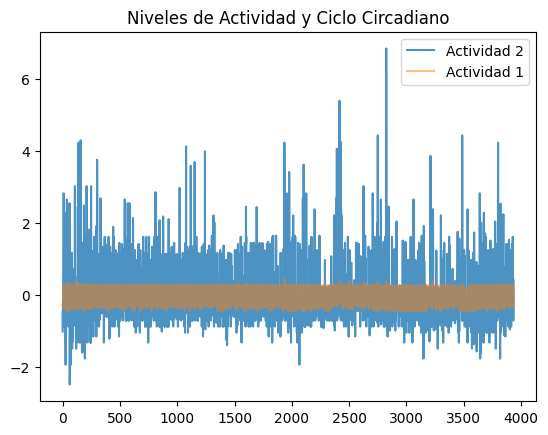

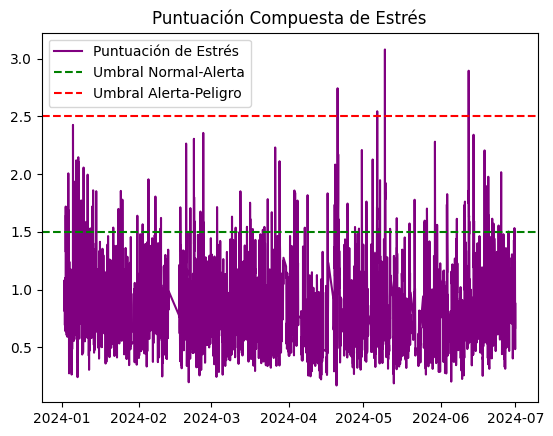

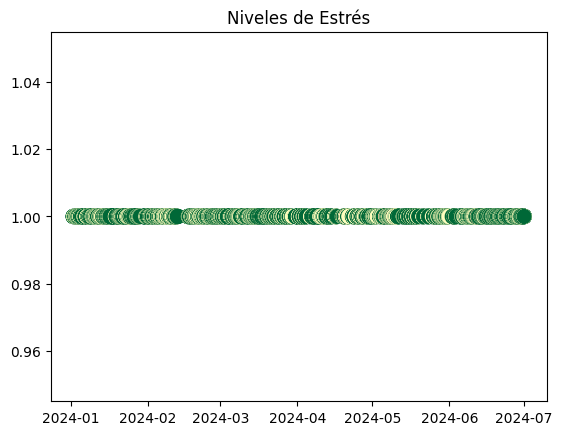

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico 1: Niveles de actividad y ciclo circadiano
plt.plot(df.index, df['activity_level_2'], label='Actividad 2', alpha=0.8)
plt.plot(df.index, df['activity_level'],label='Actividad 1', alpha=0.5)
plt.title('Niveles de Actividad y Ciclo Circadiano')
plt.legend()
plt.show()

# Gráfico 2: Puntuación compuesta y umbrales
plt.plot(results.index, results['composite_score'], label='Puntuación de Estrés', color='purple')
plt.axhline(y=1.5, color='g', linestyle='--', label='Umbral Normal-Alerta')
plt.axhline(y=2.5, color='r', linestyle='--', label='Umbral Alerta-Peligro')
plt.title('Puntuación Compuesta de Estrés')
plt.legend()
plt.show()

# Gráfico 3: Mapa de calor de factores de riesgo
stress_colors = {'normal': 0, 'alerta': 1, 'peligro': 2}
stress_values = [stress_colors[level] for level in results['stress_level']]

plt.scatter(results.index, [1]*len(results), c=stress_values, 
            cmap='RdYlGn_r', s=100)
plt.title('Niveles de Estrés')
plt.show()

In [43]:
df

Fecha  Hora  period eating  period other  period resting  \
0     2024-01-01     0          0.079           0.0           0.410   
1     2024-01-01     1          0.000           0.0           0.652   
2     2024-01-01     2          0.000           0.0           0.443   
3     2024-01-01     3          0.000           0.0           0.462   
4     2024-01-01     4          0.000           0.0           0.711   
...          ...   ...            ...           ...             ...   
3931  2024-06-30    19          1.000           0.0           0.000   
3932  2024-06-30    20          0.341           0.0           0.000   
3933  2024-06-30    21          0.000           0.0           0.551   
3934  2024-06-30    22          0.416           0.0           0.000   
3935  2024-06-30    23          1.000           0.0           0.000   

      period rumination  period eating_count  period other_count  \
0                 0.511                  1.0                 0.0   
1                 0.348                  0.0                 0.0   
2                 0.557                  0.0                 0.0   
3                 0.538                  0.0                 0.0   
4                 0.289                  0.0                 0.0   
...                 ...                  ...                 ...   
3931              0.000                  1.0                 0.0   
3932              0.659                  1.0                 0.0   
3933              0.449                  0.0                 0.0   
3934              0.584                  1.0                 0.0   
3935              0.000                  2.0                 0.0   

      period resting_count  period rumination_count  activity_level  \
0                      4.0                      2.0       -0.209528   
1                      1.0                      1.0       -0.327217   
2                      1.0                      1.0       -0.249102   
3                      2.0                      2.0       -0.256203   
4                      1.0                      1.0       -0.349269   
...                    ...                      ...             ...   
3931                   0.0                      0.0        0.261279   
3932                   0.0                      1.0        0.034052   
3933                   1.0                      2.0       -0.289468   
3934                   0.0                      1.0        0.059913   
3935                   0.0                      0.0        0.261279   

      activity_level_2            datetime  
0            -1.025107 2024-01-01 00:00:00  
1            -0.443815 2024-01-01 01:00:00  
2            -0.443815 2024-01-01 02:00:00  
3            -0.887631 2024-01-01 03:00:00  
4            -0.443815 2024-01-01 04:00:00  
...                ...                 ...  
3931          0.200319 2024-06-30 19:00:00  
3932         -0.074599 2024-06-30 20:00:00  
3933         -0.718734 2024-06-30 21:00:00  
3934         -0.074599 2024-06-30 22:00:00  
3935          0.400637 2024-06-30 23:00:00  

[3936 rows x 13 columns]

In [44]:

# Mostrar resumen de resultados
print("\nResumen de análisis de estrés:")
print(f"Total de horas analizadas: {len(results)}")
print(f"Períodos normales: {(results['stress_level'] == 'normal').sum()}")
print(f"Períodos de alerta: {(results['stress_level'] == 'alerta').sum()}")
print(f"Períodos de peligro: {(results['stress_level'] == 'peligro').sum()}")

# Identificar períodos de cambios abruptos
significant_changes = results[results['composite_score'] > 2.0]
print("\nPeríodos con cambios significativos:")
for idx, row in significant_changes.iterrows():
    print(f"\nFecha/Hora: {idx}")
    print(f"Nivel de estrés: {row['stress_level']}")
    print(f"Factores de riesgo: {', '.join(row['risk_factors'])}")


Resumen de análisis de estrés:
Total de horas analizadas: 3935
Períodos normales: 2513
Períodos de alerta: 1418
Períodos de peligro: 4

Períodos con cambios significativos:

Fecha/Hora: 2024-01-03 14:00:00
Nivel de estrés: alerta
Factores de riesgo: 

Fecha/Hora: 2024-01-05 11:00:00
Nivel de estrés: alerta
Factores de riesgo: reducción_descanso, reducción_rumia

Fecha/Hora: 2024-01-06 18:00:00
Nivel de estrés: alerta
Factores de riesgo: reducción_descanso

Fecha/Hora: 2024-01-07 14:00:00
Nivel de estrés: alerta
Factores de riesgo: reducción_alimentación

Fecha/Hora: 2024-01-07 16:00:00
Nivel de estrés: alerta
Factores de riesgo: 

Fecha/Hora: 2024-01-07 18:00:00
Nivel de estrés: alerta
Factores de riesgo: 

Fecha/Hora: 2024-01-09 17:00:00
Nivel de estrés: alerta
Factores de riesgo: reducción_descanso

Fecha/Hora: 2024-02-19 21:00:00
Nivel de estrés: alerta
Factores de riesgo: 

Fecha/Hora: 2024-02-23 00:00:00
Nivel de estrés: alerta
Factores de riesgo: reducción_rumia

Fecha/Hora: 202